In [1]:
import pandas as pd
from importlib import reload
from config import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import helpers as hp
# reload(hp)
from sklearn.preprocessing import minmax_scale
import pickle

Constants are defined in config.py and they all have uppercase.

# 1) Loading dataset

Data types will be cast to the most appropriate types, to reduce memory usage.

In [2]:
df = pd.read_csv(DF_TRAIN_FILE_PATH, 
                 dtype=DATA_CAST_DICT, index_col=INDEX
)
df.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
UniqueID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [3]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [4]:
rows, cols = df.shape

print("Dataset shape")
print(20*'-')
print(f"No of rows: {rows}\nNo of cols: {cols}")
print(20*'-')

Dataset shape
--------------------
No of rows: 233154
No of cols: 40
--------------------


In [5]:
df[LABEL].value_counts(normalize=True) * 100

0    78.292888
1    21.707112
Name: loan_default, dtype: float64

We are dealing with skewed dataset. <i>Label 0</i> (didn't returned loan) takes roughly <b>78%</b> and <i>label 1</i> (returned loan) <b>21%</b>. That means we shall NOT consider <i>accuracy</i> as our main metric when modelling.

In [6]:
df.isna().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS               

Only one attribute has NaNs, so the process of fixing NaNs will be relativelly easy.
<br><br>
Data exploring will be done using all data, however every transformation will be extracted into function and in transformer class (compatible with sklearns transfomers), located in helpers.py.

In [7]:
df_orig = df.copy()

# 2) Dataset analysis

## Data types

In [8]:
# Rename column names for consistency
df.rename(columns={"PRIMARY.INSTAL.AMT": "PRI.INSTAL.AMOUNT",
                    "SEC.INSTAL.AMT": "SEC.INSTAL.AMOUNT"}, inplace=True)

# Replace dots in column names with underscore
df.columns = [a.replace(".", "_") for a in df.columns]

# Fix date formats for 'Date_of_Birth' 
# For example, year 18 should be treated as 2018, year 63 as 1963 and so on.
def fix_date(date: str) -> int:
    day, month, year = date.split('-')
    year = int(year)
    
    # 2019 was the year dataset was aquired
    if 0 <= year <= 19:
        year_fixed = year + 2000
    else:
        year_fixed = year + 1900

    date_fixed = '-'.join([day, month, str(year_fixed)])
    return date_fixed

# Fixing date format for columns 'Date_of_Birth', 'DisbursalDate' and converting them to datetime
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'].apply(fix_date), format="%d-%m-%Y")
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'].apply(fix_date), format="%d-%m-%Y")

# Fix duration format for columns 'AVERAGE_ACCT_AGE' & 'CREDIT_HISTORY_LENGTH'
def duration(dur: str) -> int:
    years = int(dur.split(' ')[0].replace('yrs',''))
    months = int(dur.split(' ')[1].replace('mon',''))
    
    # Returns duration in months
    return months + 12 * years

df['AVERAGE_ACCT_AGE'] = df['AVERAGE_ACCT_AGE'].apply(duration).astype('uint16')
df['CREDIT_HISTORY_LENGTH'] = df['CREDIT_HISTORY_LENGTH'].apply(duration).astype('uint16')

# Calculate age of loanee using its date of birth
df['Age'] = ((pd.Timestamp(2019, 1, 1) - df['Date_of_Birth']) / np.timedelta64(1, 'Y'))

# Define numerical, nominal and ordinal column names
numerical = ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS_SCORE', 
             'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
             'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
             'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
             'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
             'SEC_DISBURSED_AMOUNT', 'PRI_INSTAL_AMOUNT', 'SEC_INSTAL_AMOUNT',
             'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
             'NO_OF_INQUIRIES', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'Age'
]
ordinal = ['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag']

nominal = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
'Employment_Type', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag', 'PERFORM_CNS_SCORE_DESCRIPTION',
]

other = ['Date_of_Birth', 'DisbursalDate']

# Numeric features

In following cells every column is going to be inspected: its values, distribution (if numeric), unusual values... If there are unknown or NaNs, they will be taken care of.
<br>
<br>
As we go columns will be added to their appropriate lists (numeric, ordinal, nominal, deletion) for keeping track of progress more easily.
<br>
<br>
2  more datesets will be made: one which has logarithm function applied on numerical columns and second that has its outliers replaced using boxplot and clipping. These two datasets will be of use for visual inspection of feature distributions and boxplots.

In [9]:
df_no_outliers = hp.NumericColumnsTransformer(method='outlier_replacement').fit_transform(df, columns=numerical)
df_logged = hp.NumericColumnsTransformer(method='log').fit_transform(df, columns=numerical)

df_names = ["df", "df_no_outliers", "df_logged"]

df


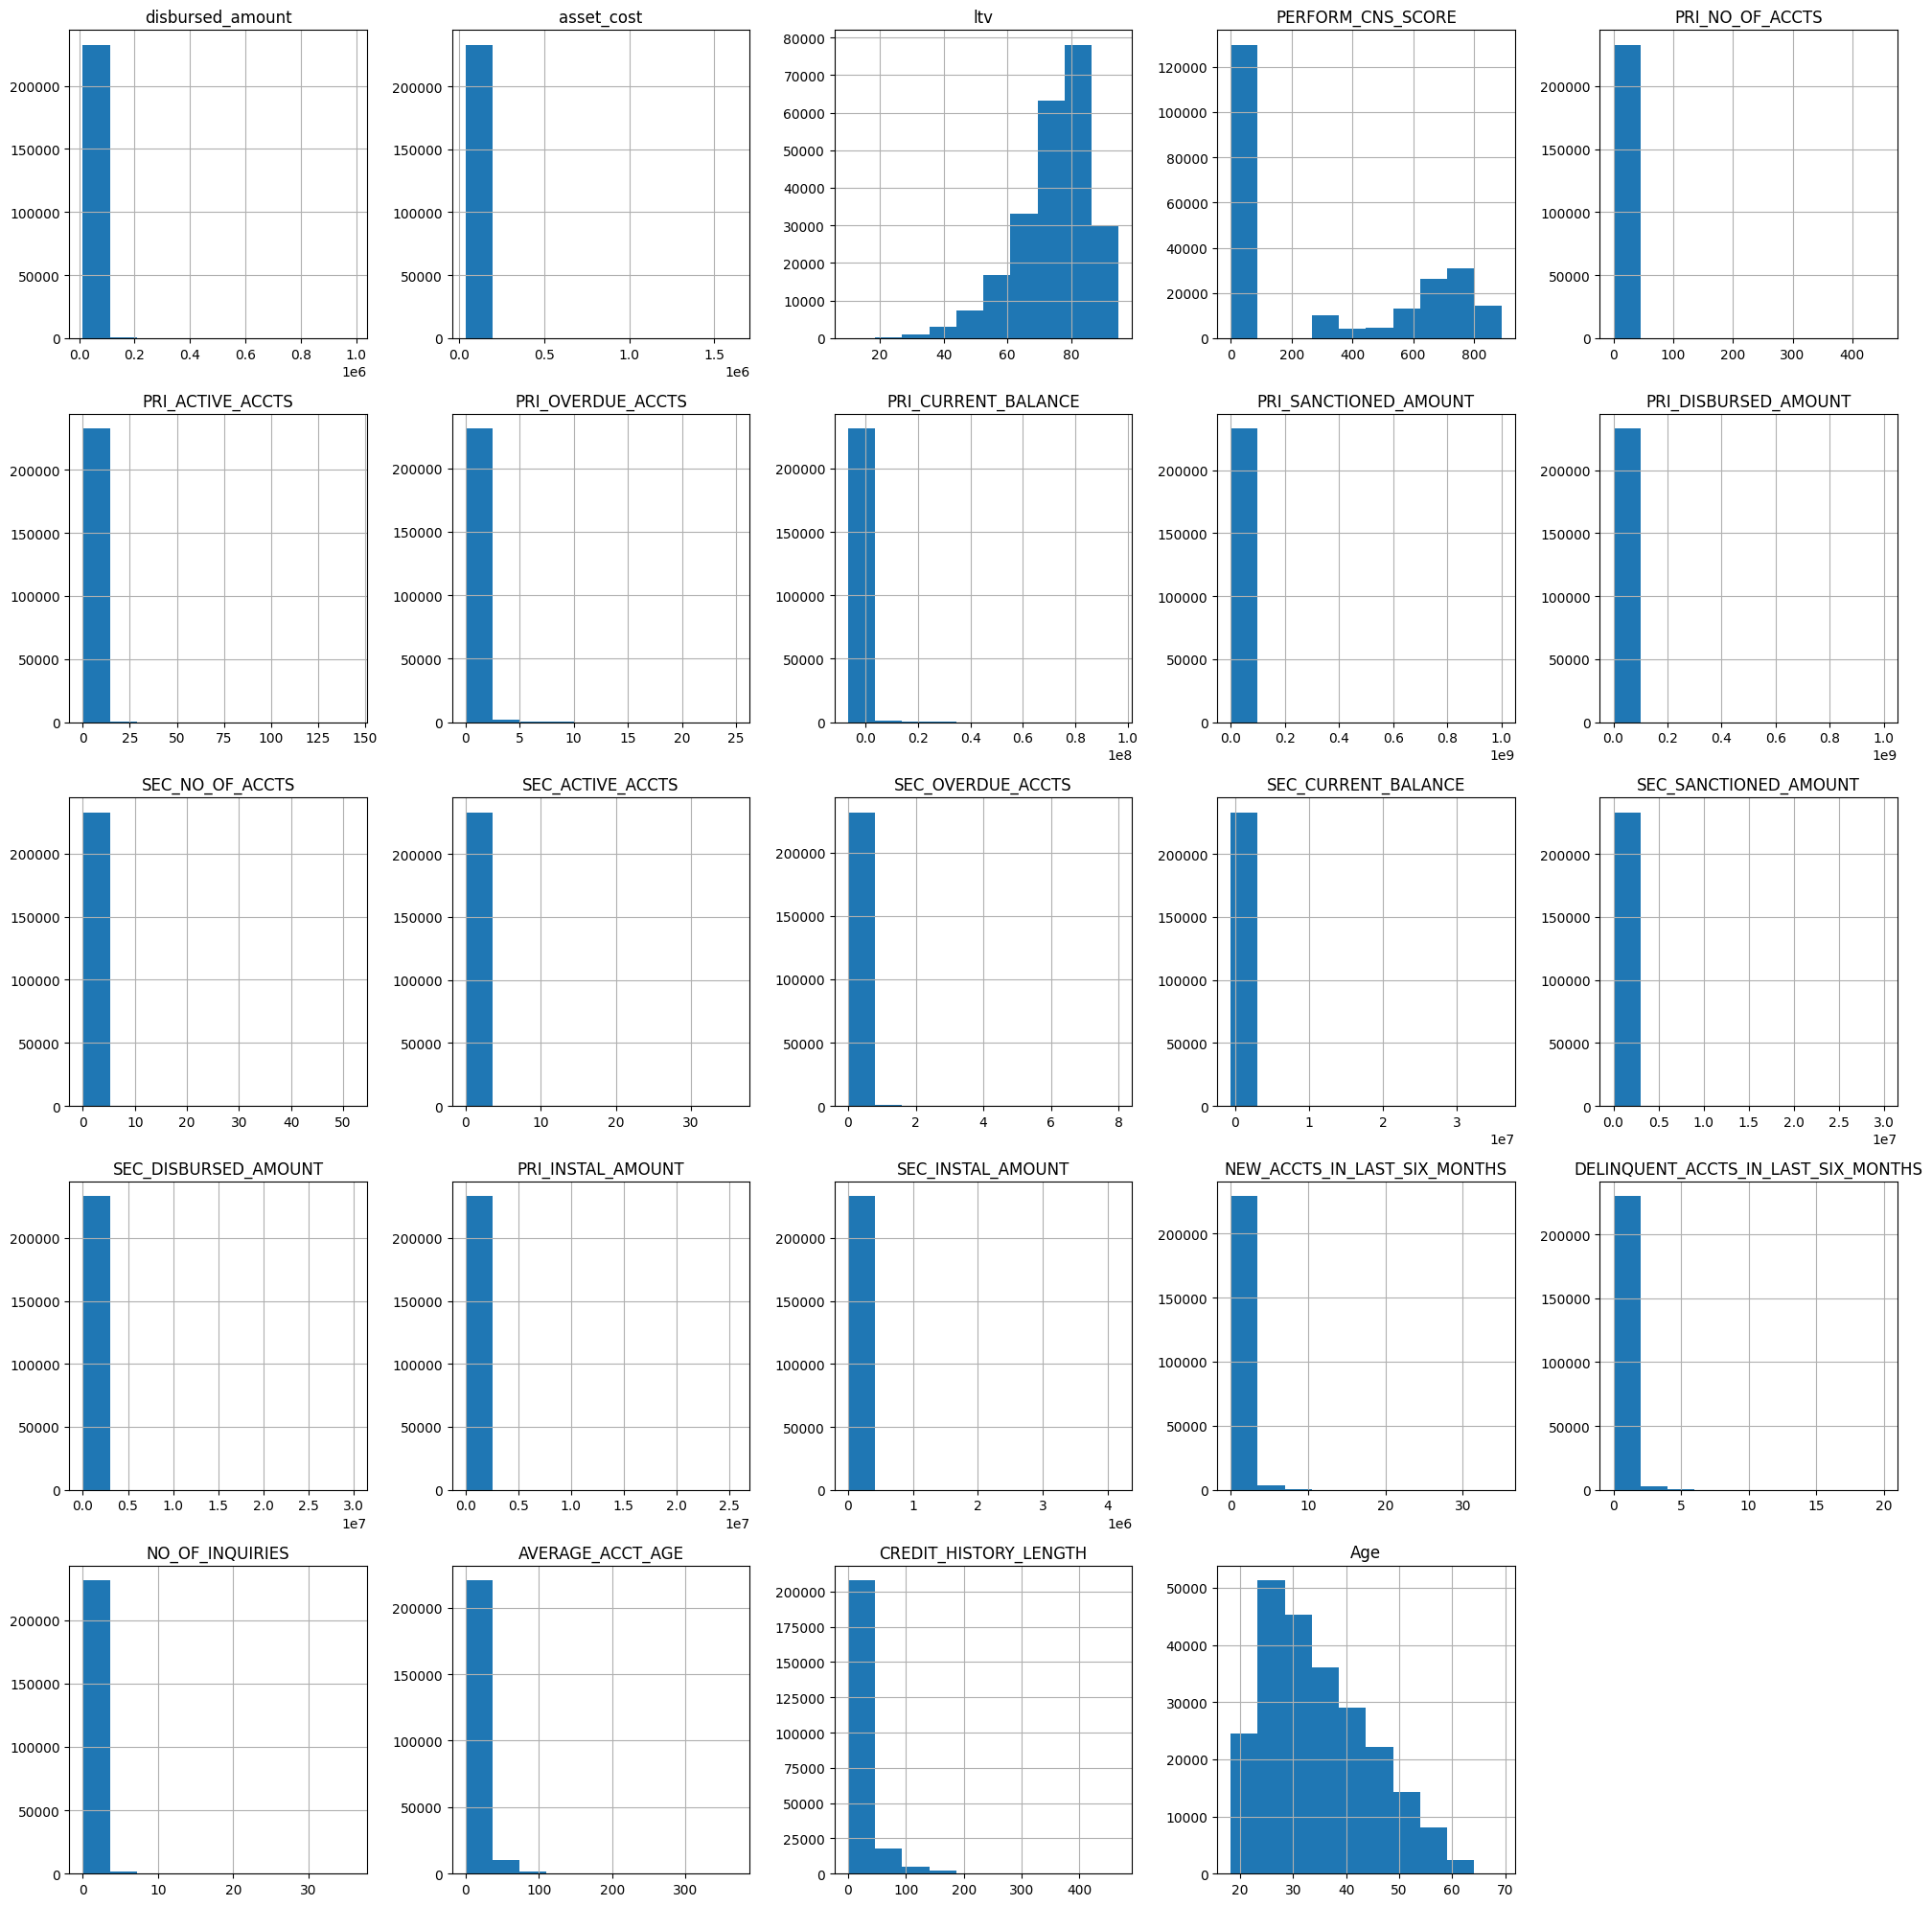

df_no_outliers


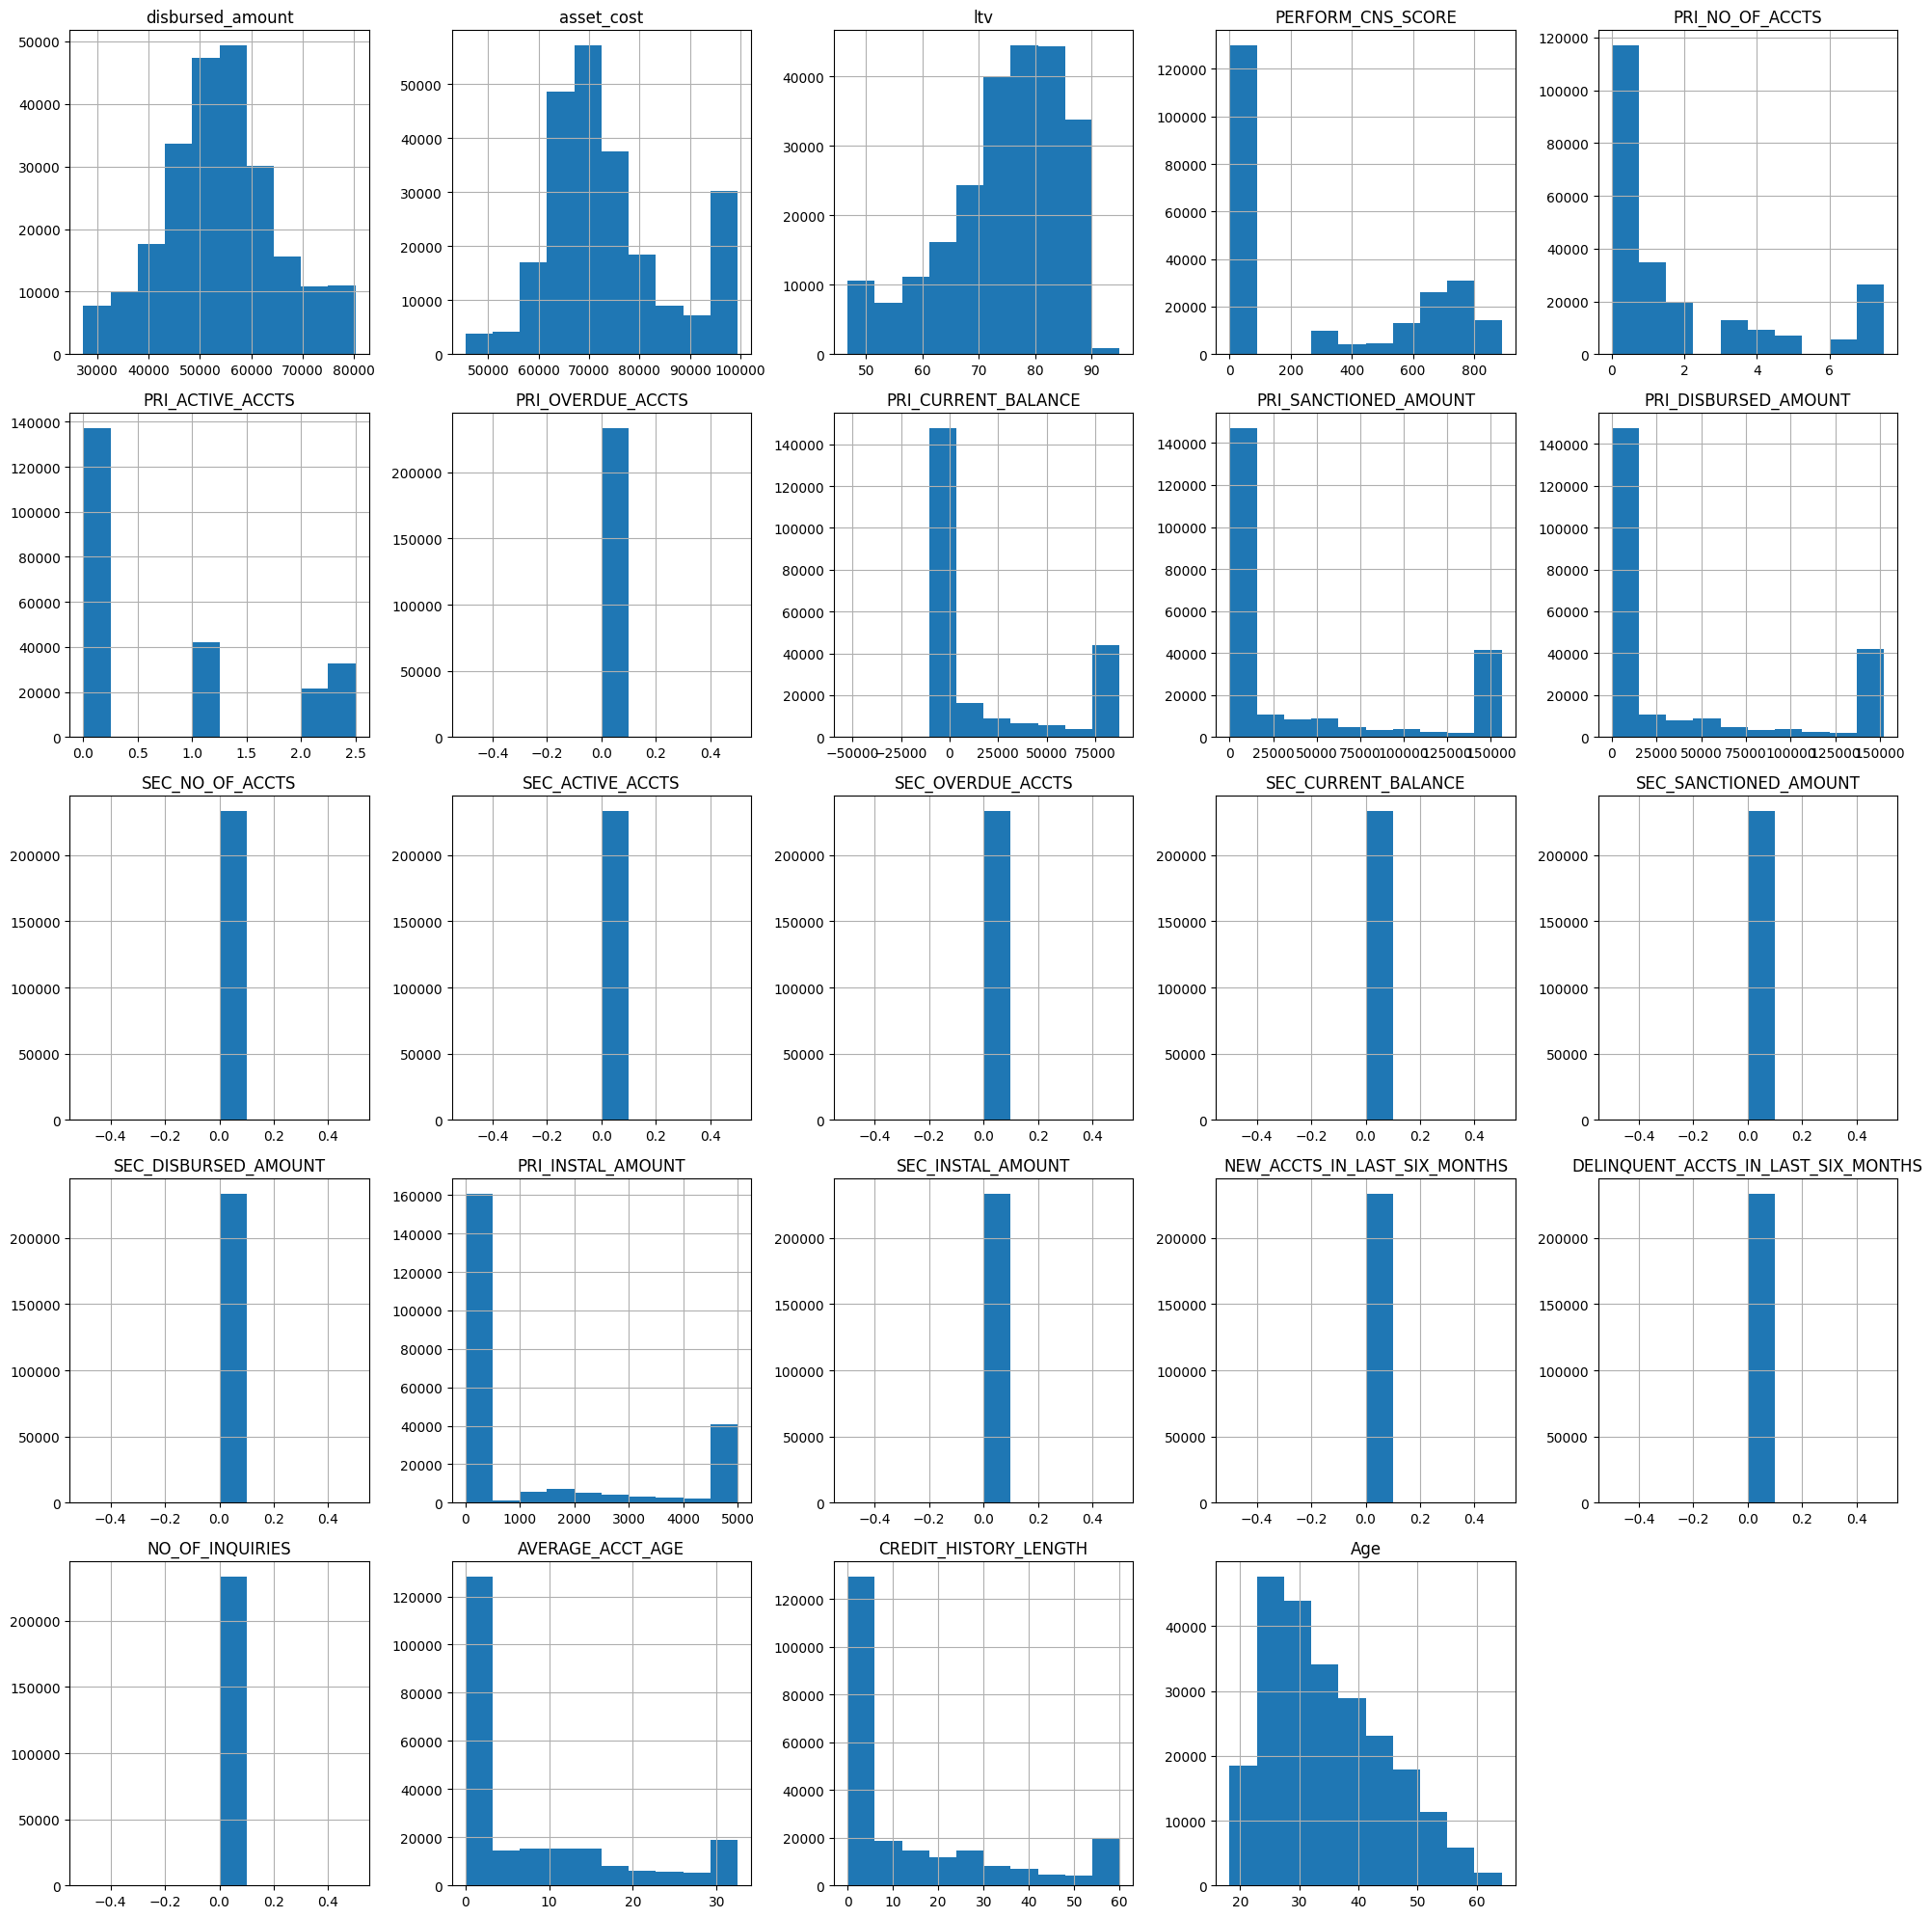

df_logged


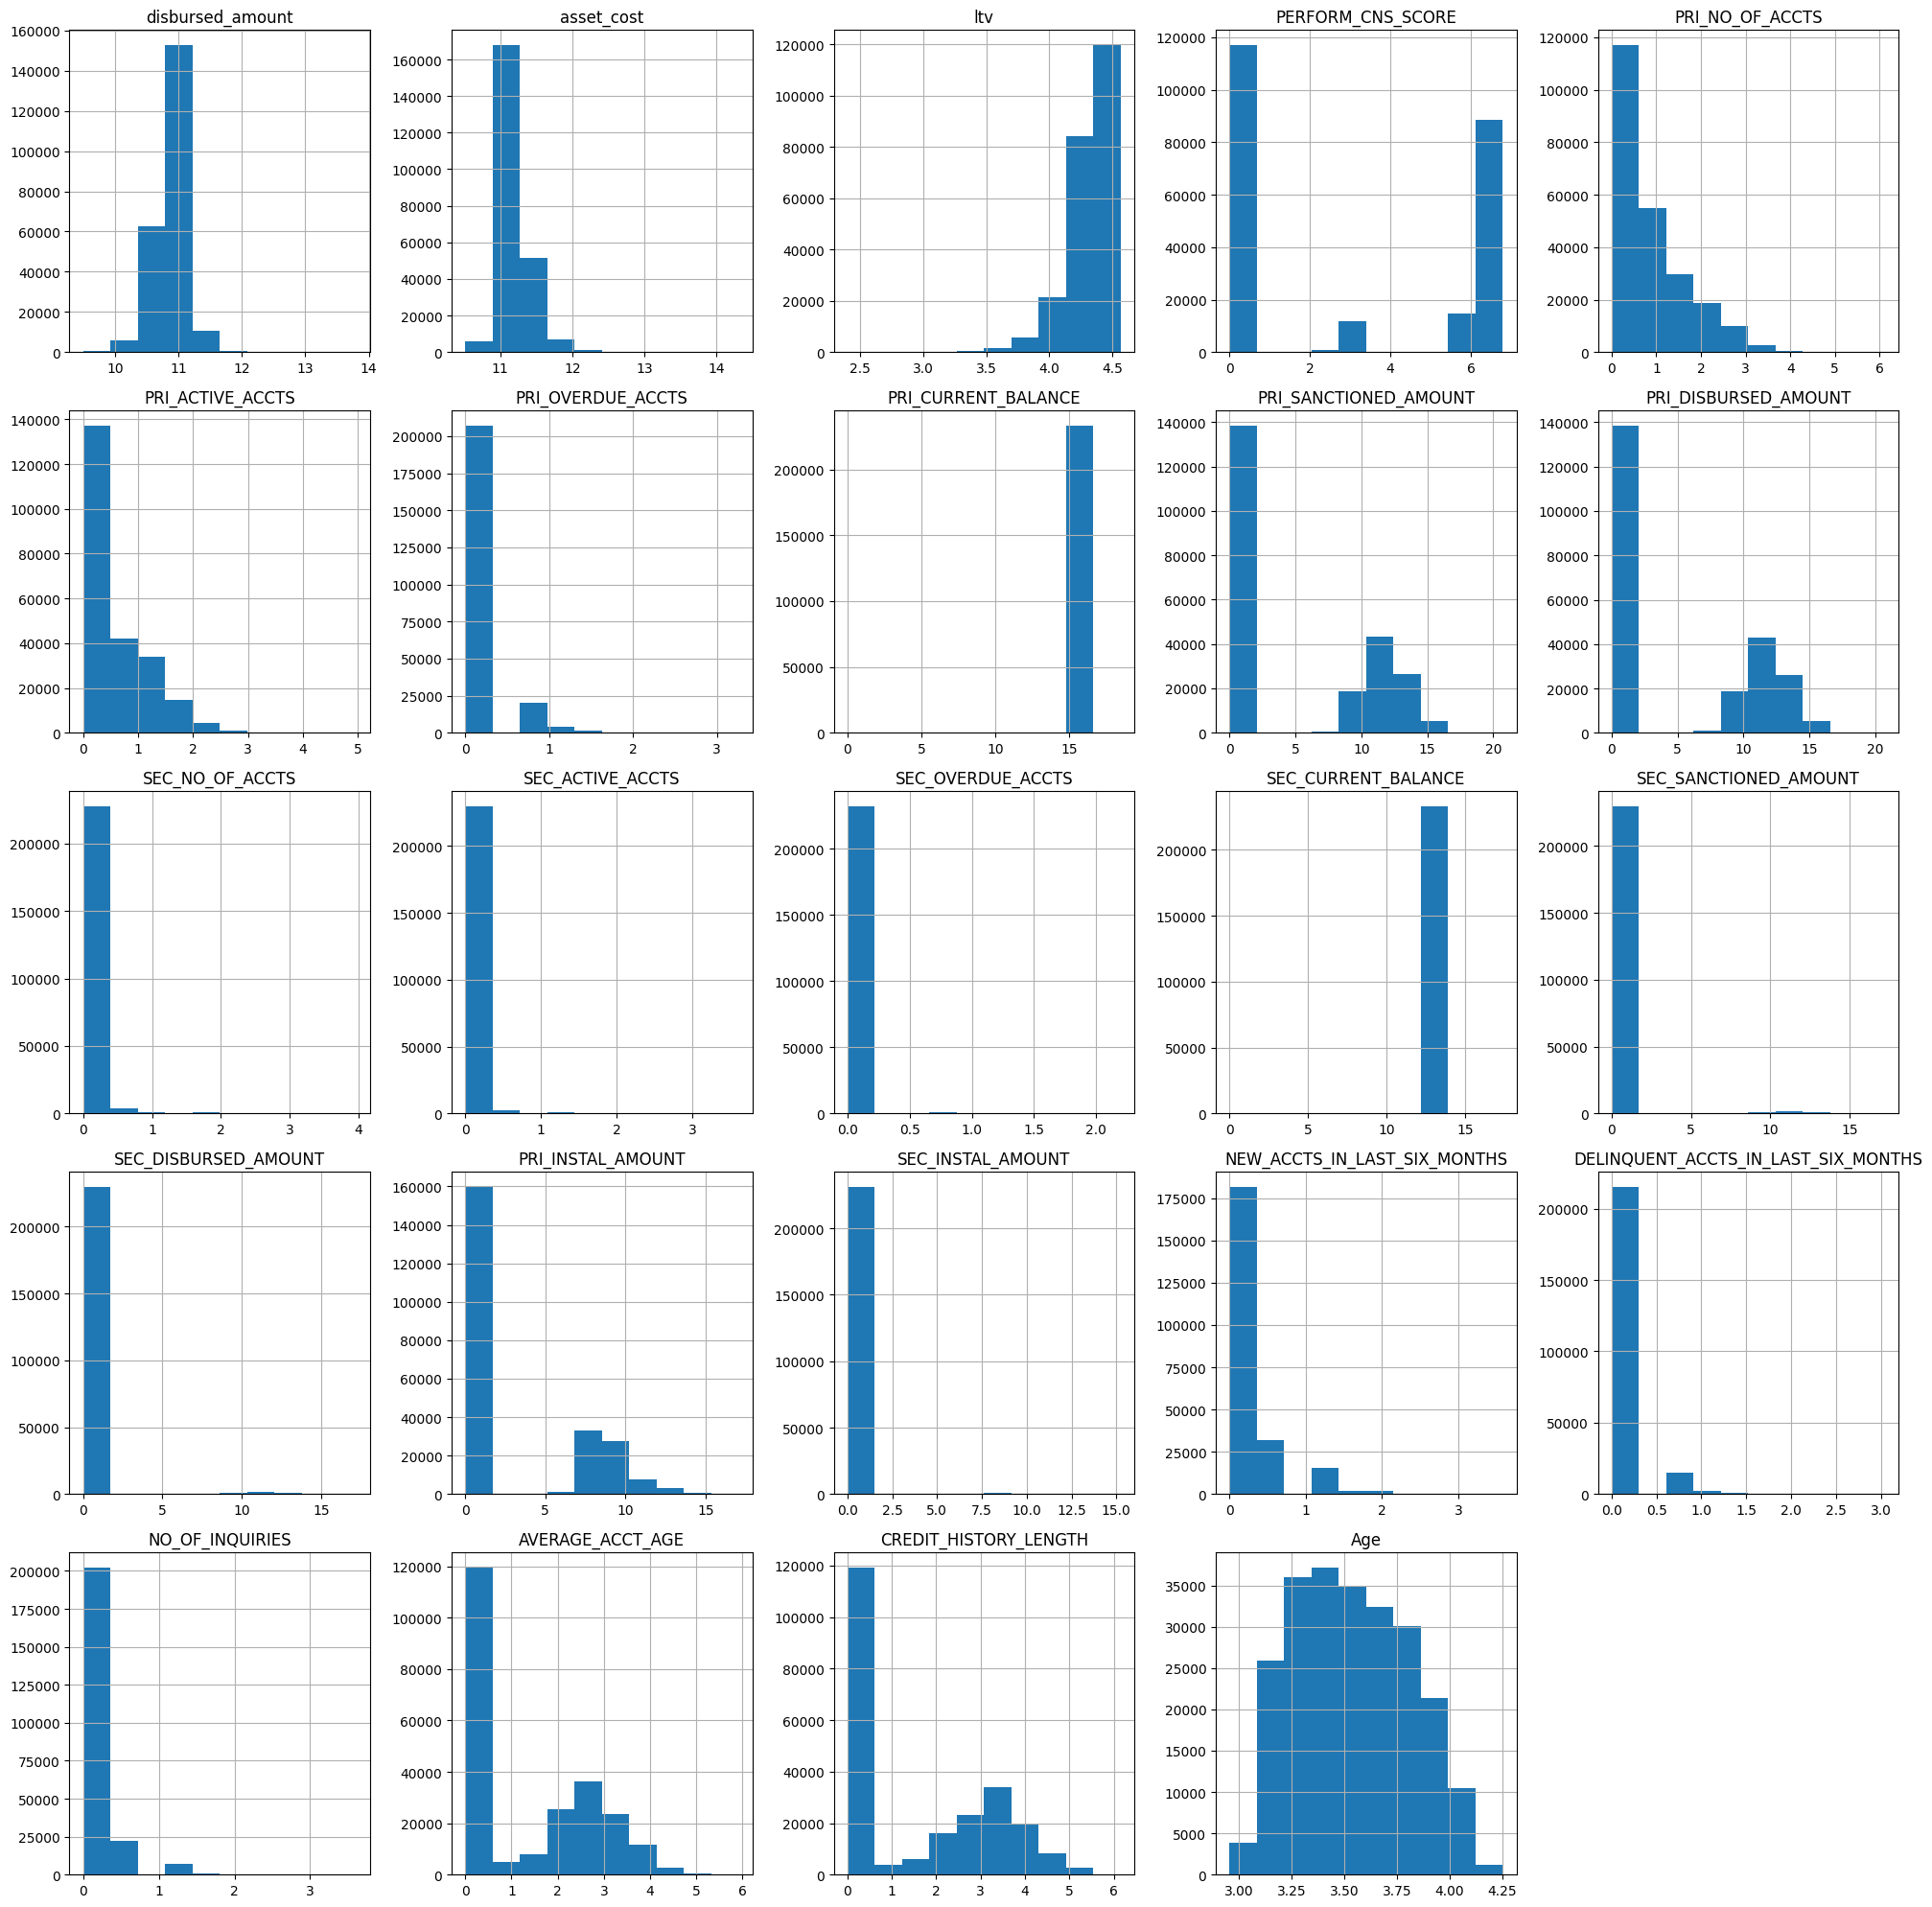

In [10]:
# Display histograms
for df_name in df_names:
    print(f"{df_name}")
    df_ = globals()[f'{df_name}']
    df_.hist(column=numerical, figsize=(20, 20), layout=(5, 5))
    plt.tight_layout()
    plt.savefig(f"data/images/{df_name}_hist.png")
    plt.show();

df


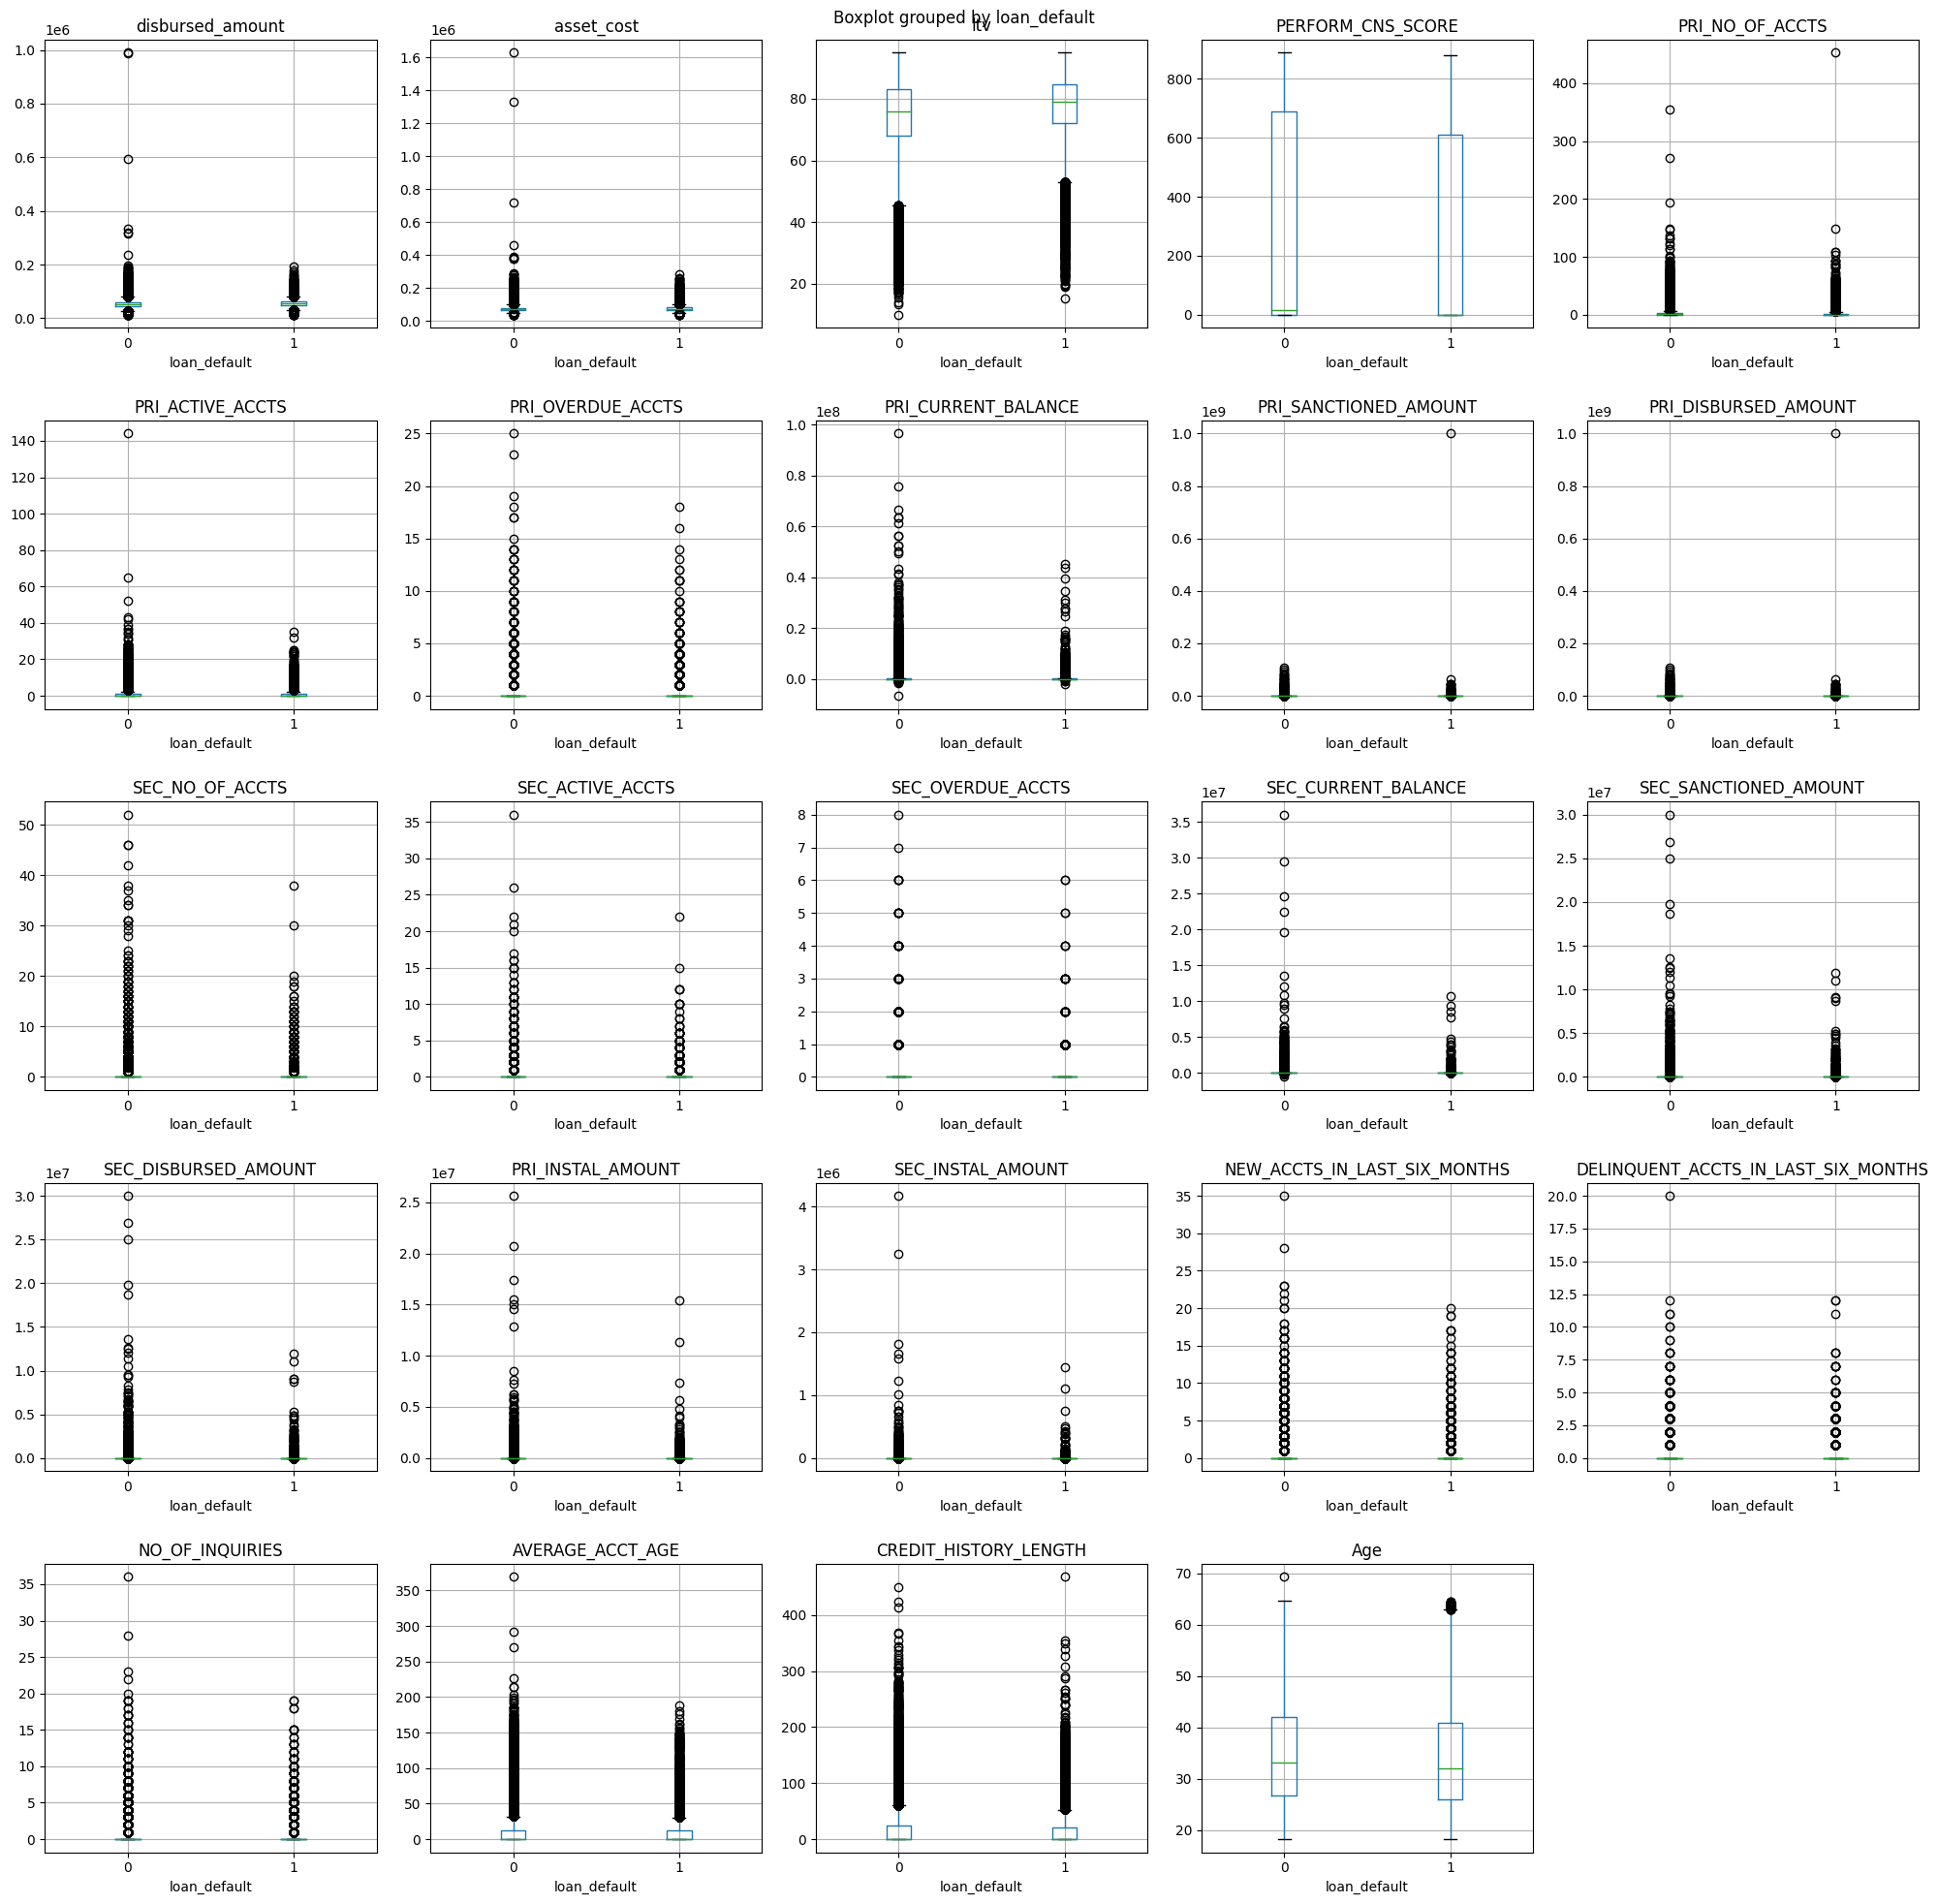

df_no_outliers


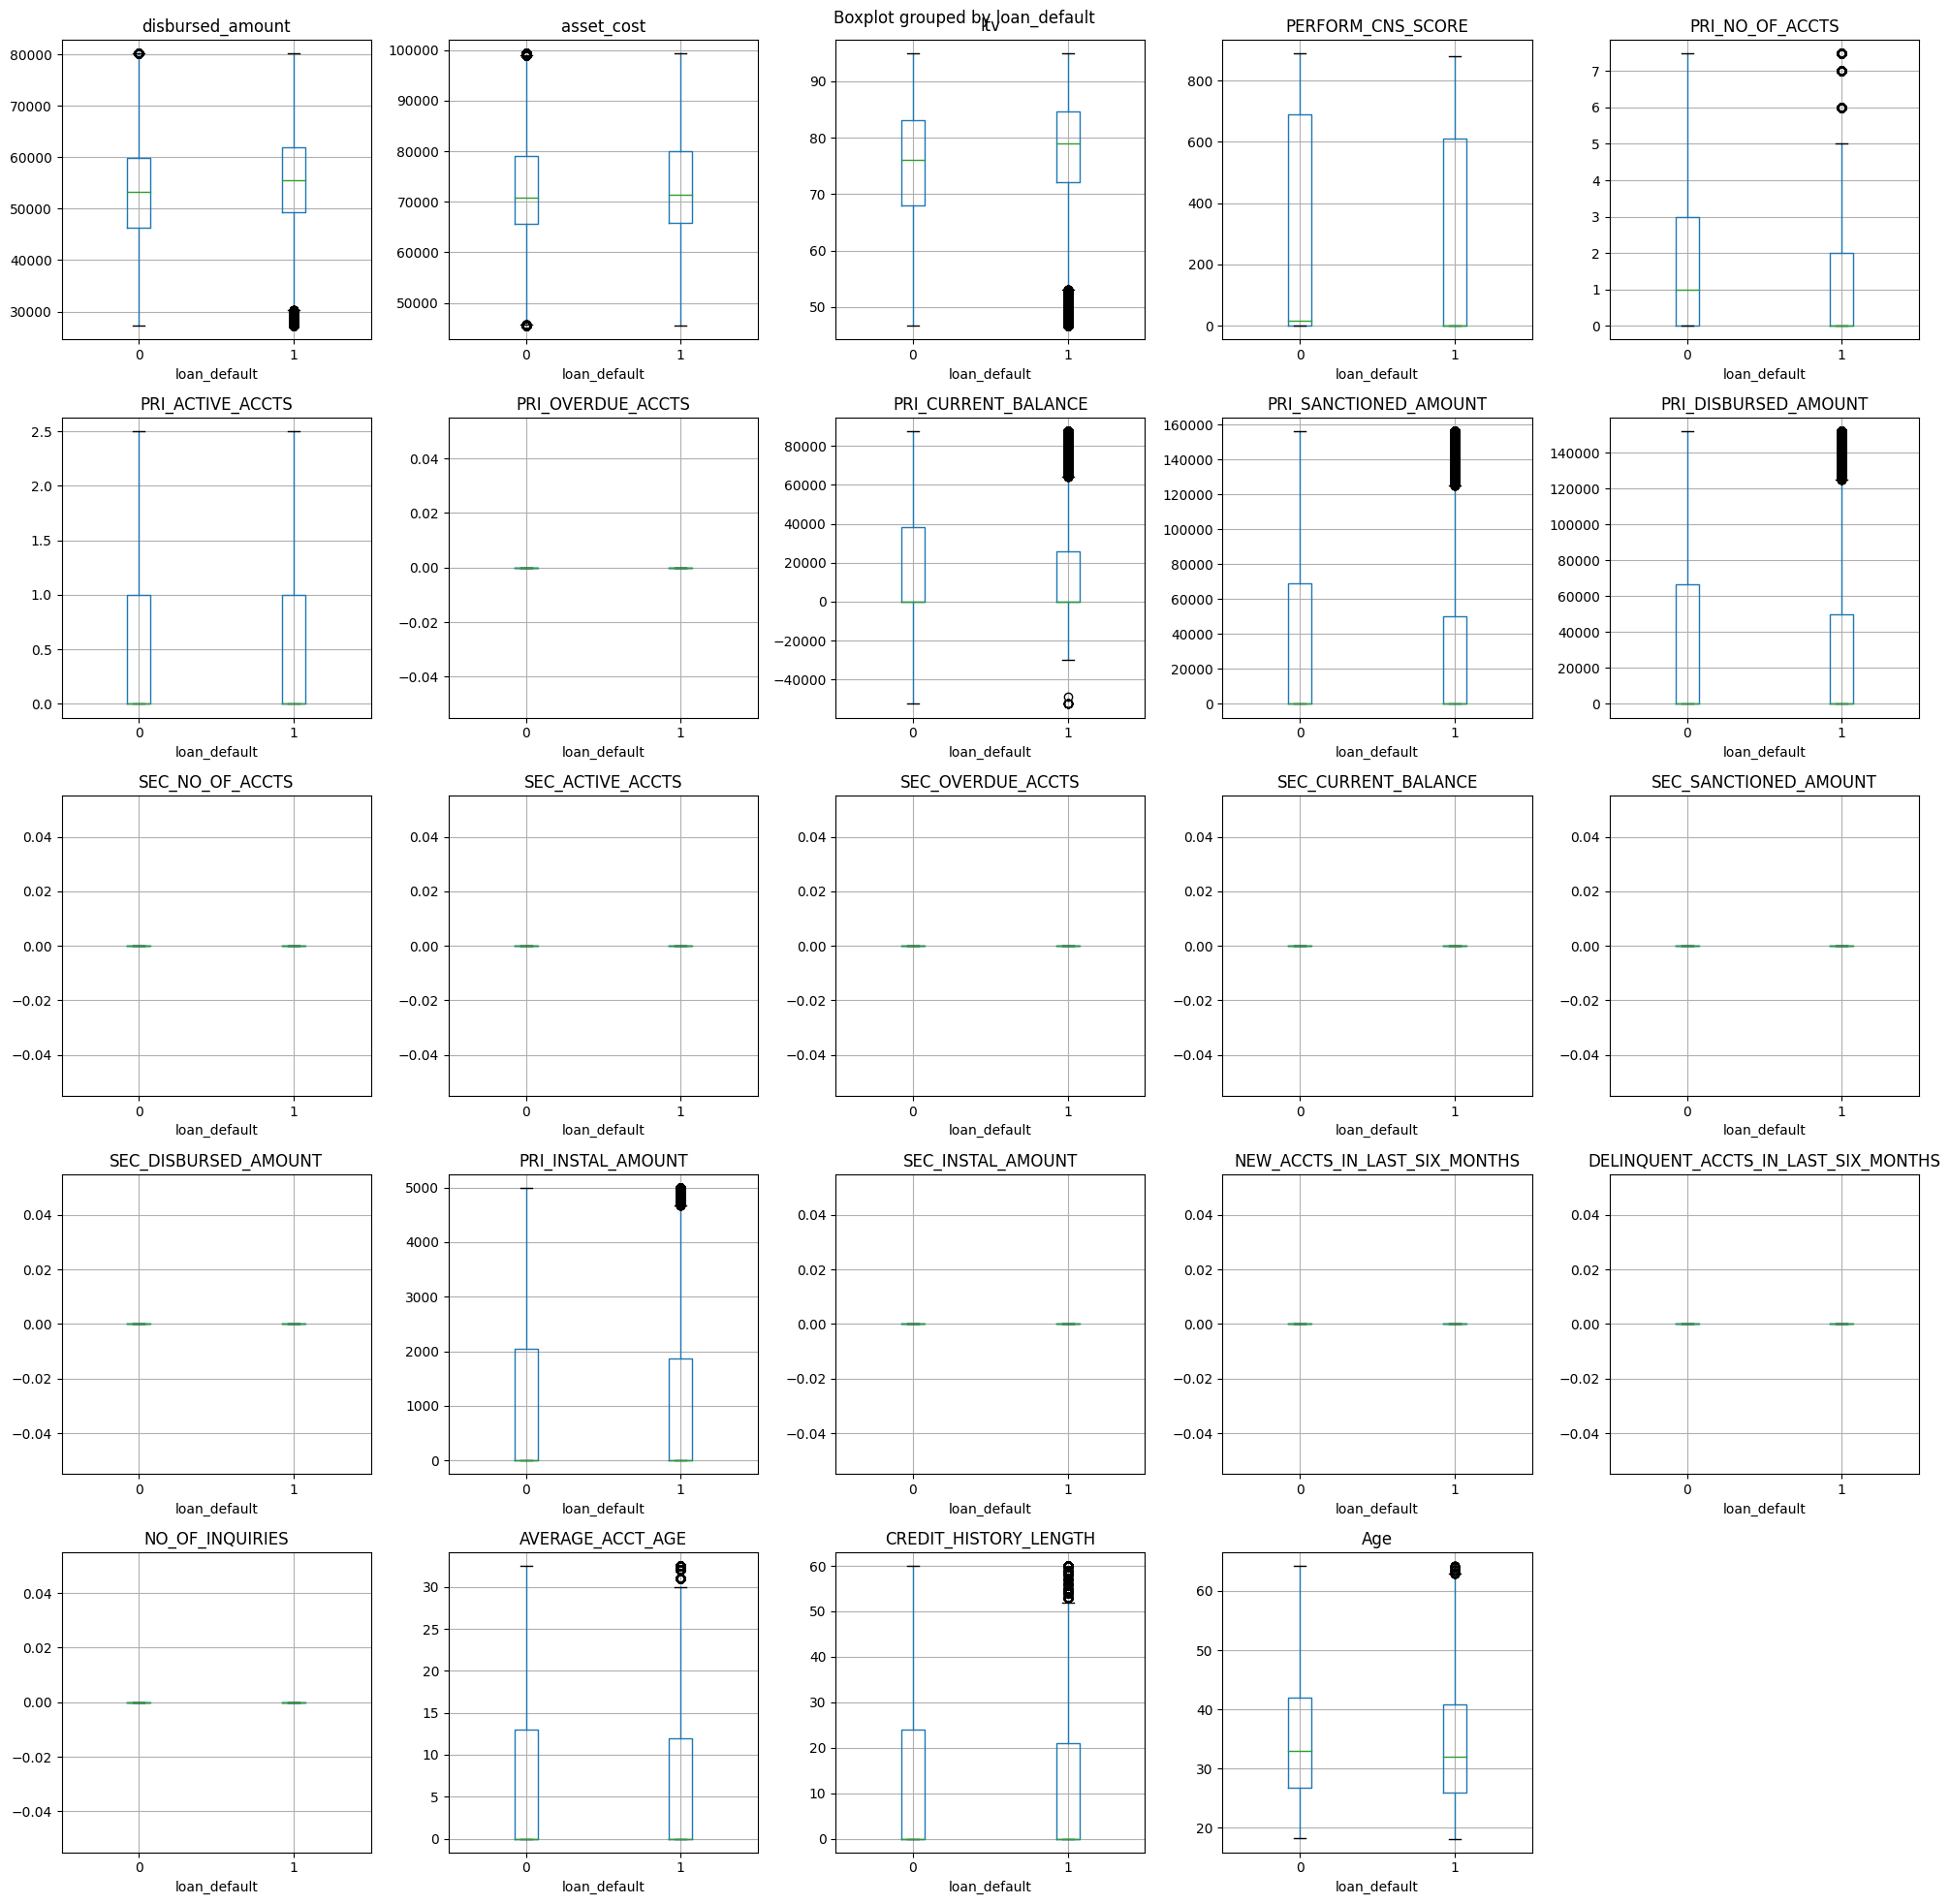

df_logged


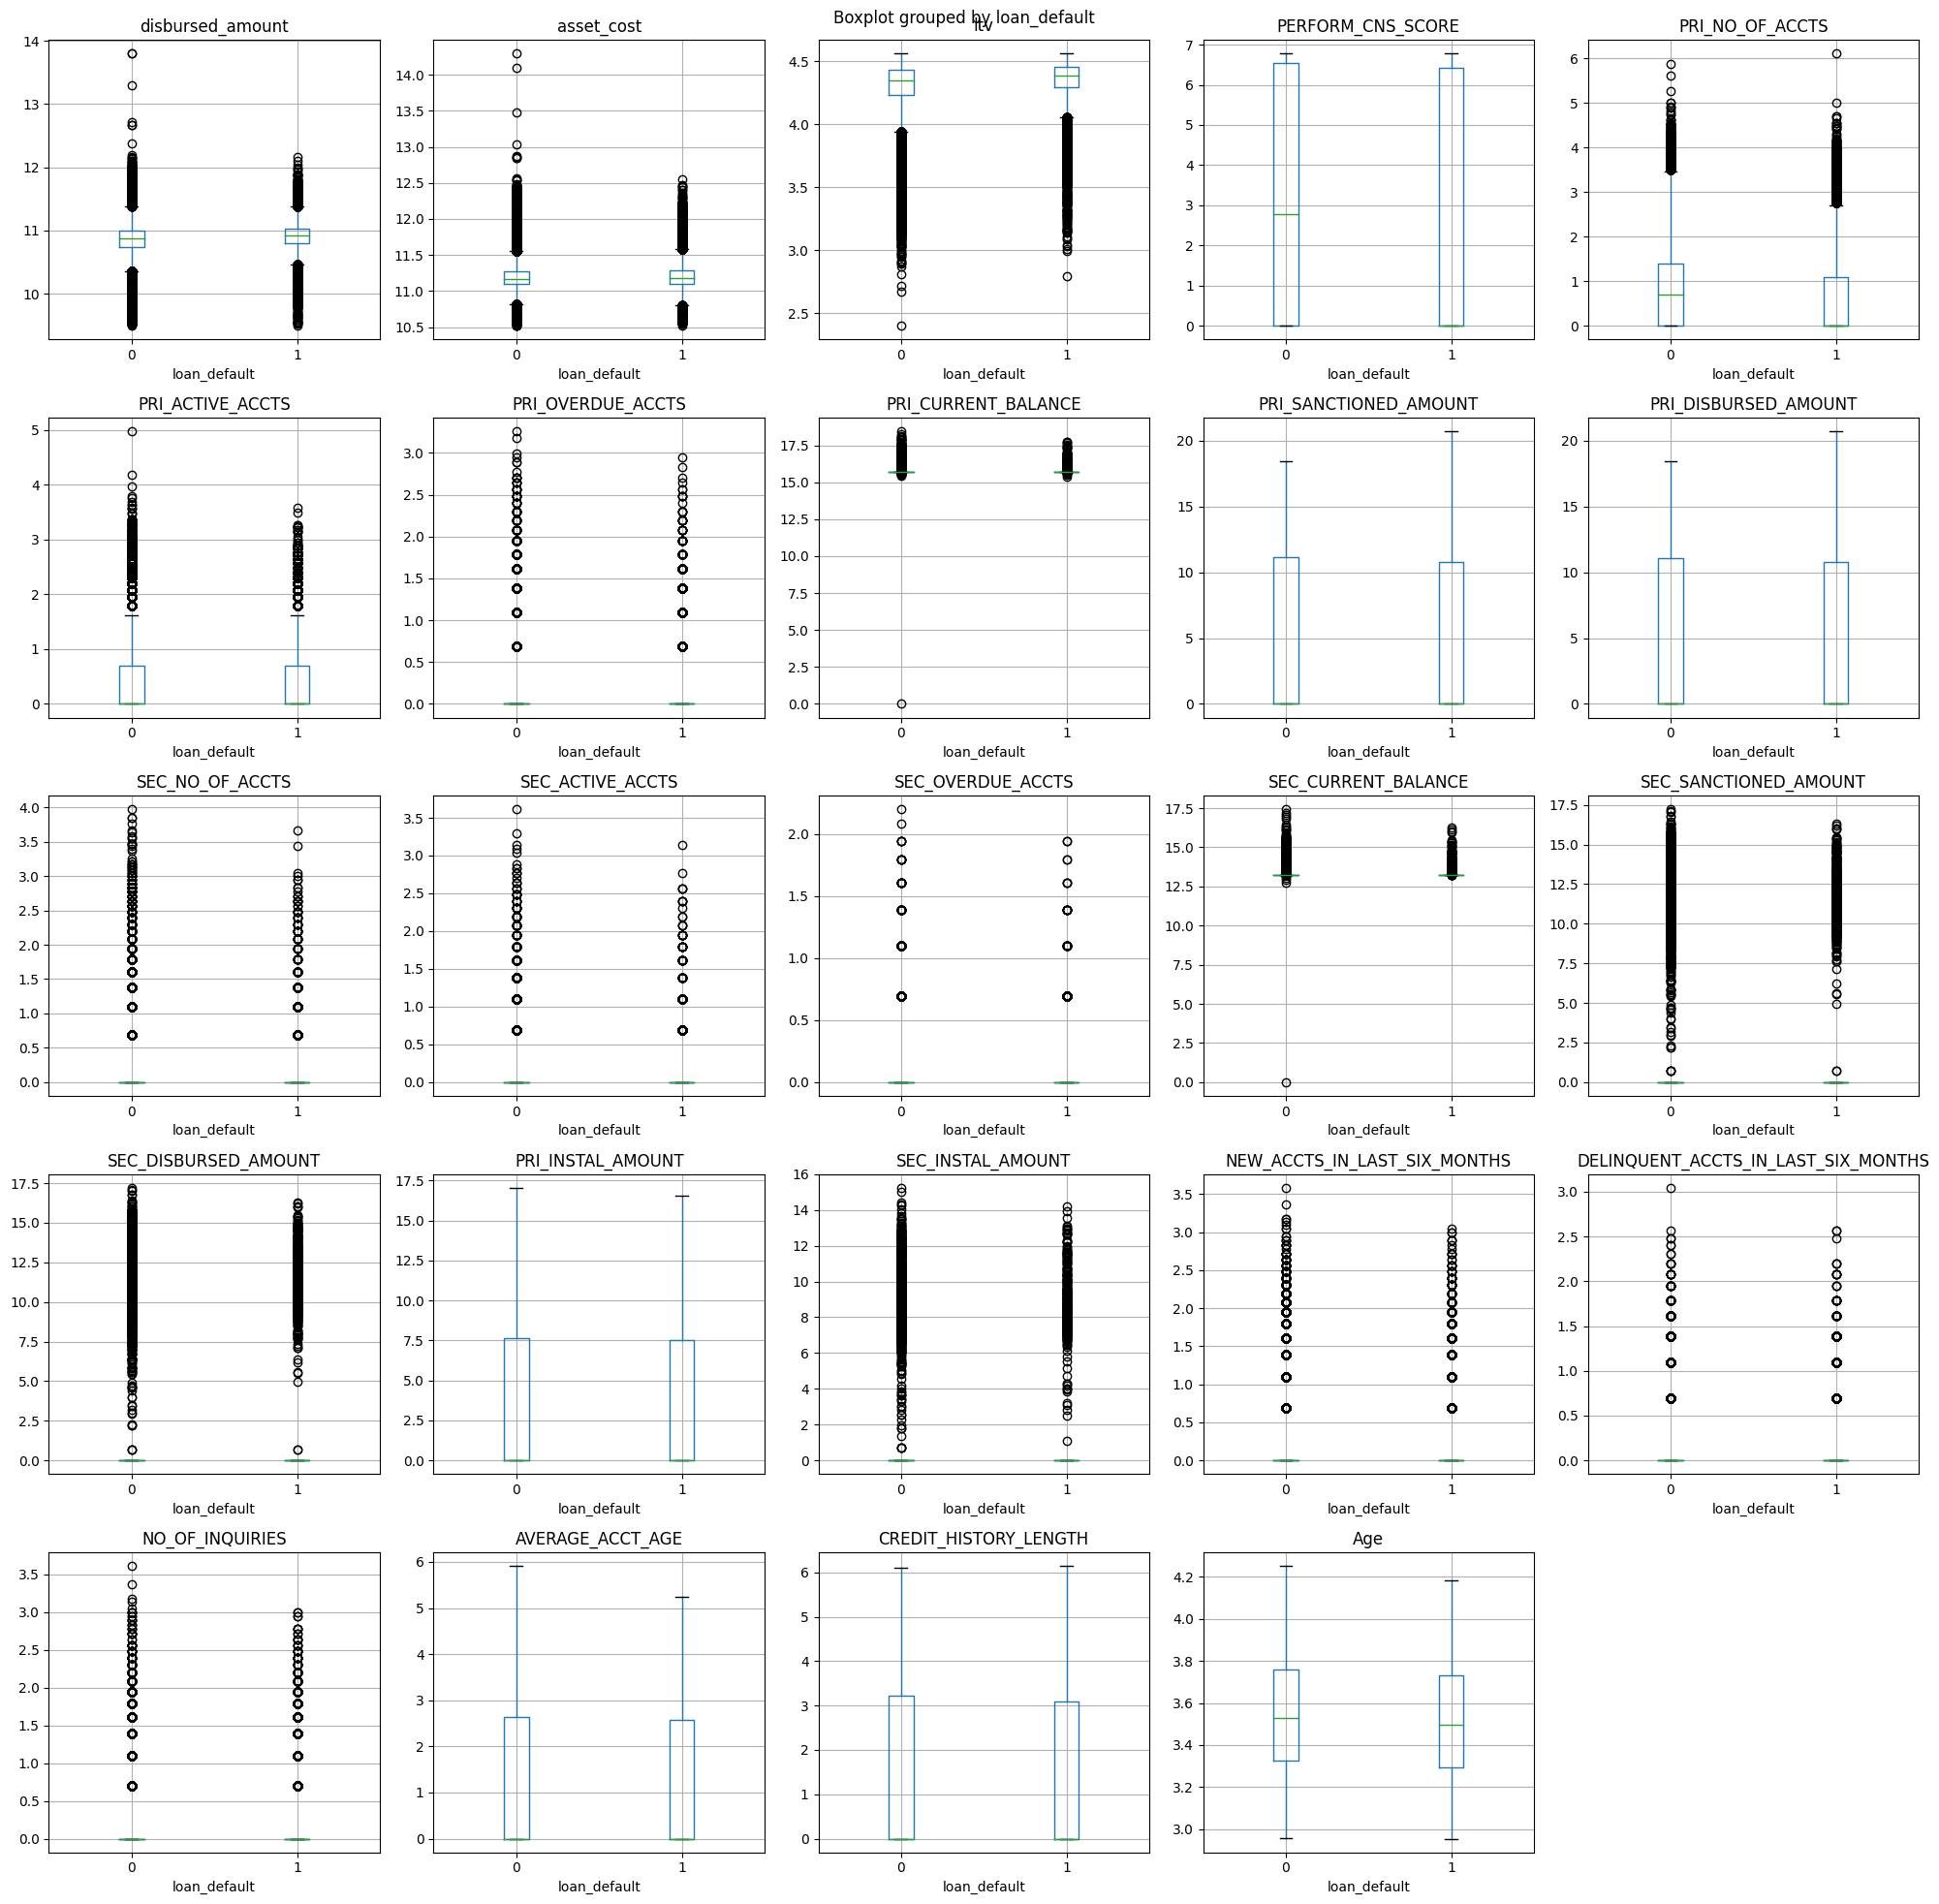

In [11]:
# Display boxplots
for df_name in df_names:  
    print(f"{df_name}")
    df_ = globals()[f'{df_name}']
    df_.boxplot(column=numerical, figsize=(20, 20), by=LABEL, layout=(5,5), sharey=False, sharex=False)
    plt.tight_layout()
    plt.savefig(f"data/images/{df_name}_box.png")
    plt.show();

In [12]:
del df_no_outliers, df_logged

In [13]:
df[numerical].describe()

,disbursed_amount,asset_cost,ltv,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRI_INSTAL_AMOUNT,SEC_INSTAL_AMOUNT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,Age
count,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,...,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,54356.993528,7.586507e+04,74.746530,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,...,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,8.915764,16.252404,34.743521
std,12971.314171,1.894478e+04,11.456636,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,...,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,15.106416,28.581255,9.824259
min,13320.000000,3.700000e+04,10.030000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,18.198868
25%,47145.000000,6.571700e+04,68.880000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,26.620670
50%,53803.000000,7.094600e+04,76.800000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,32.999993
75%,60413.000000,7.920175e+04,83.670000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,...,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,13.000000,24.000000,41.662731
max,990572.000000,1.628992e+06,95.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,...,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,369.000000,468.000000,69.296426


In [14]:
pri_cols = [a for a in numerical if a.startswith("PRI_")]
sec_cols = [a for a in numerical if a.startswith("SEC_")]

'PERFORM_CNS_SCORE' will be processed later.
<br>
<br>
It's very unusal why there are people with negative current balance. abs() function will be applied onto the values.

In [15]:
# Some lonees had negative current balance, so applying absolute 
# value will make irregular values positive and thus valid
df['PRI_CURRENT_BALANCE'] = df['PRI_CURRENT_BALANCE'].abs()
df['SEC_CURRENT_BALANCE'] = df['SEC_CURRENT_BALANCE'].abs()

Let's see Pearson correlations for all numerical cols.

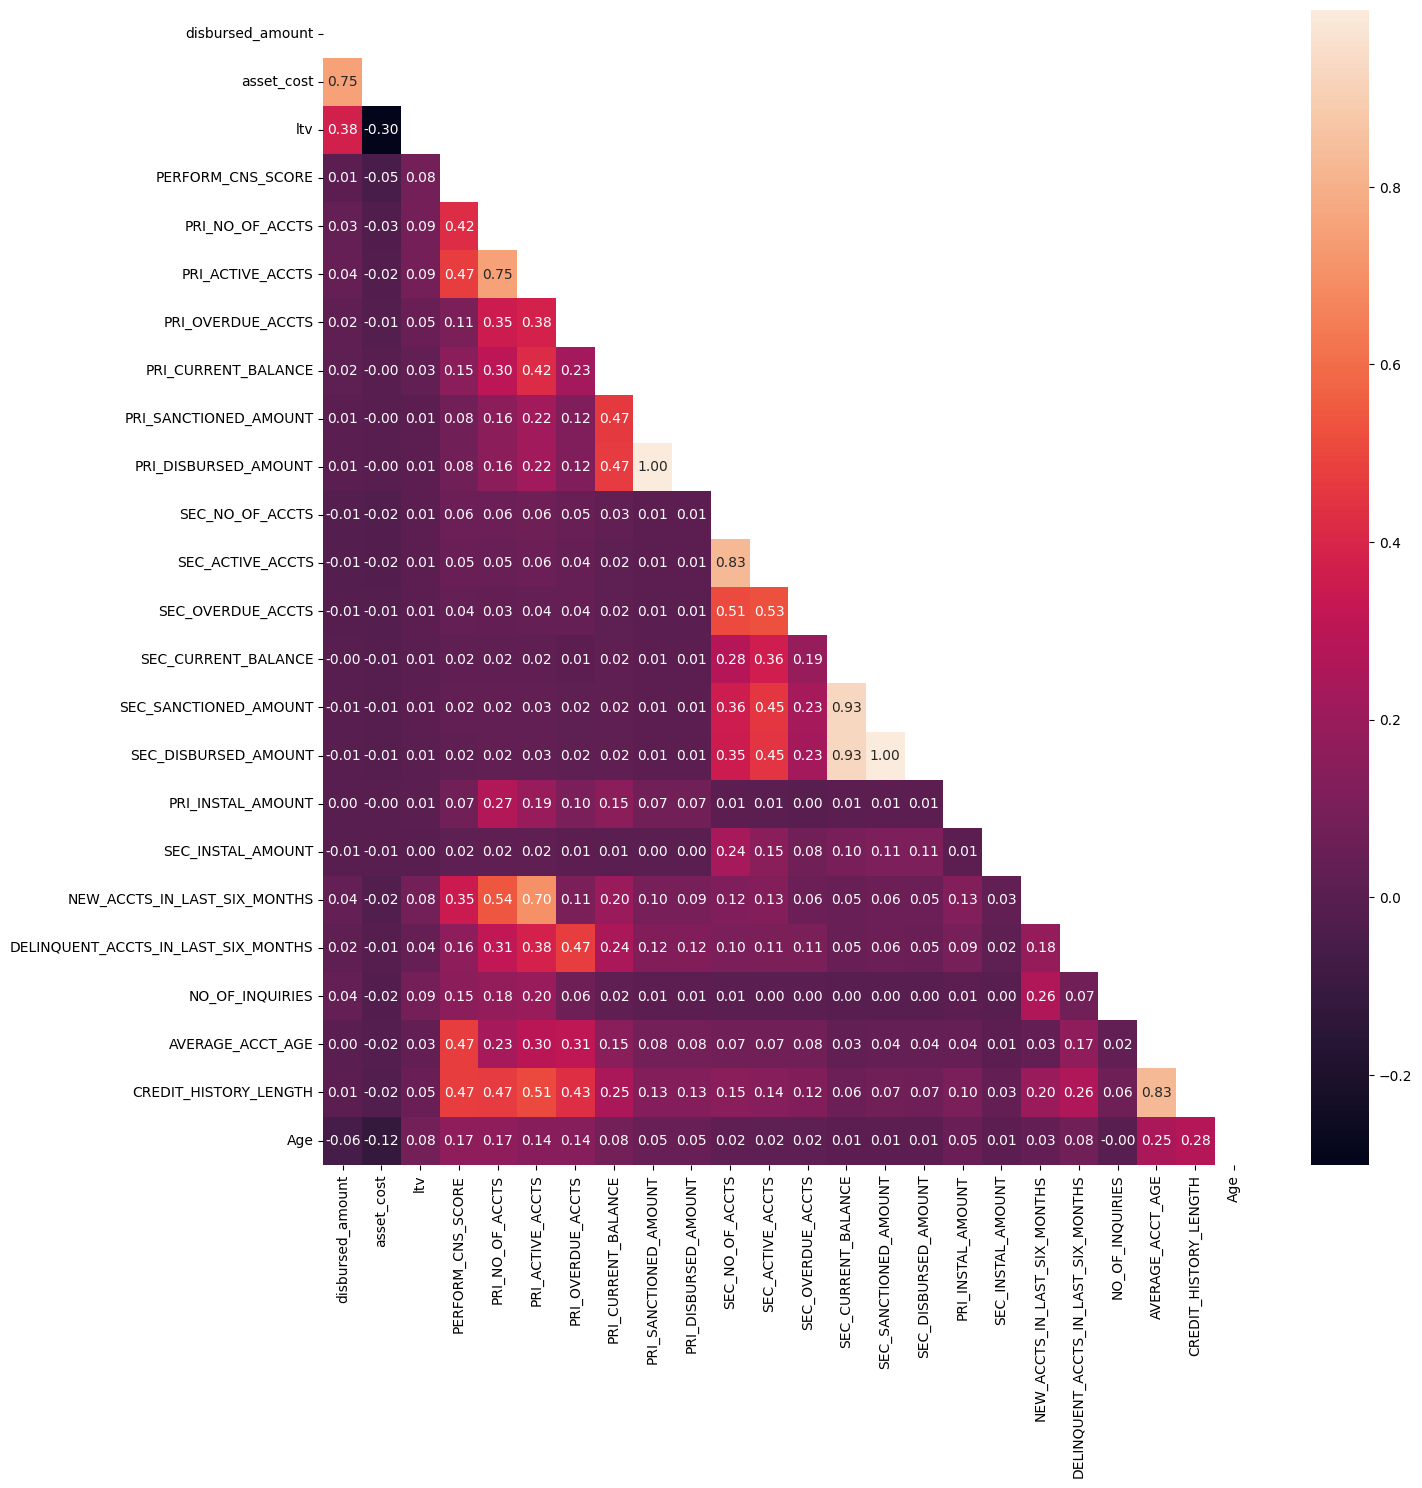

In [16]:
plt.figure(figsize=(15, 15))
corr = df[numerical].corr()

# Upper triangular heatmap of correlations with annotations
sns.heatmap(corr, annot=True, mask=np.triu(corr), fmt='.2f');

Let's investigate relationship between 'x_CURRENT_BALANCE' & 'x_SANCTIONED_AMOUNT'.

Pearson correlations:
PRI: 0.4650870379832337
SEC: 0.9293495060892277


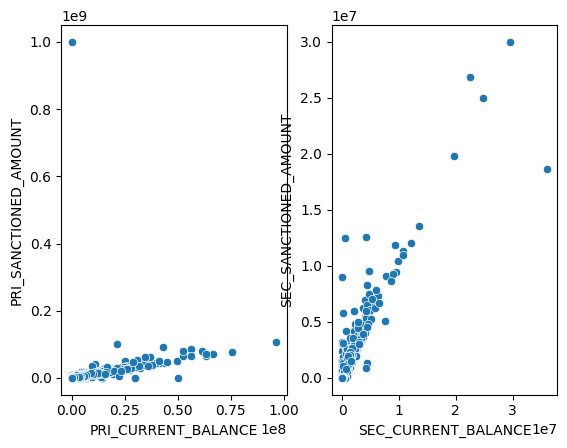

In [17]:
fig, axs = plt.subplots(1, 2)

sns.scatterplot(data=df, x='PRI_CURRENT_BALANCE', y='PRI_SANCTIONED_AMOUNT', ax=axs[0])
sns.scatterplot(data=df, x='SEC_CURRENT_BALANCE', y='SEC_SANCTIONED_AMOUNT', ax=axs[1])

print("Pearson correlations:")
print(f"PRI: {np.corrcoef(df['PRI_CURRENT_BALANCE'], df['PRI_SANCTIONED_AMOUNT'])[0][1]}")
print(f"SEC: {np.corrcoef(df['SEC_CURRENT_BALANCE'], df['SEC_SANCTIONED_AMOUNT'])[0][1]}")

It may seem strange that 'PRI_SANCTIONED_AMOUNT' & 'PRI_CURRENT_BALANCE' aren't much correlated, but the outlier in upper left corner is actually causing the misinformation.
<br>
<br>
After excluding the value temporarily, Pearson's correlation coefficient changed from 0.465 to 0.950.

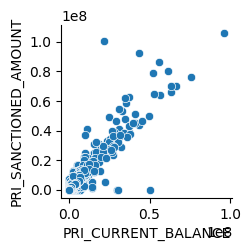

PRI_CURRENT_BALANCE correlation: 0.9502294753703049


In [18]:
temp_sanctioned = df['PRI_SANCTIONED_AMOUNT'] != df['PRI_SANCTIONED_AMOUNT'].max()

sns.pairplot(data=df.loc[temp_sanctioned, :], x_vars='PRI_CURRENT_BALANCE', y_vars='PRI_SANCTIONED_AMOUNT')
plt.show()

print(f"PRI_CURRENT_BALANCE correlation: {np.corrcoef(df.loc[temp_sanctioned, 'PRI_CURRENT_BALANCE'], df.loc[temp_sanctioned, 'PRI_SANCTIONED_AMOUNT'])[0][1]}")

Therefore, there's no point keeping columns 'PRI_CURRENT_BALANCE' & 'SEC_CURRENT_BALANCE'. 
<br>
<br>
Also, columns 'PRI_DISBURSED_AMOUNT' & 'SEC_DISBURSED_AMOUNT' will be removed due to high correlation with 'PRI_SANCTIONED_AMOUNT' / 'SEC_SANCTIONED_AMOUNT'

In [19]:
# Drop 'x_CURRENT_BALANCE' & 'x_DISBURSED_AMOUNT' for high
# correlation with 'x_SANCTIONED_AMOUNT' (PRI and SEC)
df = df.drop(['PRI_CURRENT_BALANCE', 'SEC_CURRENT_BALANCE',
              'PRI_DISBURSED_AMOUNT', 'SEC_DISBURSED_AMOUNT'], axis=1)

# Update numerical and pri & sec columns
for column_list in (numerical, pri_cols, sec_cols):
    [column_list.remove(a) for a in column_list[:] if a in ['PRI_CURRENT_BALANCE', 'SEC_CURRENT_BALANCE', 
                                                            'PRI_DISBURSED_AMOUNT', 'SEC_DISBURSED_AMOUNT']]

It seems there is a small number of people who possess secondary loans. This will further be investigated in feature engineering part.

In [20]:
print(f"People who have secondary loans: {df[df['SEC_NO_OF_ACCTS'] != 0].shape[0]}")

People who have secondary loans: 5865


# Categorical features

In [21]:
# Display value counts for every categorical column
for col in ordinal + nominal:
    print(f"Column: {col}")
    c = df[col].value_counts(dropna=False)
    p = df[col].value_counts(dropna=False, normalize=True) * 100

    display(pd.concat([c, p], axis=1, keys=['counts', '%']))
    print()

Column: Aadhar_flag


,counts,%
1,195924,84.032013
0,37230,15.967987



Column: PAN_flag


,counts,%
0,215533,92.442334
1,17621,7.557666



Column: VoterID_flag


,counts,%
0,199360,85.505717
1,33794,14.494283



Column: Driving_flag


,counts,%
0,227735,97.675785
1,5419,2.324215



Column: Passport_flag


,counts,%
0,232658,99.787265
1,496,0.212735



Column: branch_id


,counts,%
2,13138,5.634902
67,11328,4.858591
3,9230,3.958757
5,9218,3.953610
36,8832,3.788054
...,...,...
217,183,0.078489
261,176,0.075487
84,156,0.066909
111,89,0.038172



Column: supplier_id


,counts,%
18317,1432,0.614186
15694,1300,0.557571
15663,1275,0.546849
17980,1268,0.543847
14234,1258,0.539558
...,...,...
18631,1,0.000429
23768,1,0.000429
23038,1,0.000429
20315,1,0.000429



Column: manufacturer_id


,counts,%
86,109534,46.979250
45,56626,24.286952
51,27204,11.667825
48,16710,7.166937
49,10220,4.383369
120,9658,4.142327
67,2405,1.031507
145,778,0.333685
153,12,0.005147
152,6,0.002573



Column: Current_pincode_ID


,counts,%
2578,1880,0.806334
1446,1731,0.742428
1515,1087,0.466215
2989,934,0.400594
2943,899,0.385582
...,...,...
5913,1,0.000429
4010,1,0.000429
2189,1,0.000429
2141,1,0.000429



Column: Employment_Type


,counts,%
Self employed,127635,54.742788
Salaried,97858,41.971401
NaN,7661,3.285811



Column: State_ID


,counts,%
4,44870,19.244791
3,34078,14.616091
6,33505,14.370330
13,17884,7.670467
9,16022,6.871853
8,14197,6.089108
5,10177,4.364926
14,9414,4.037675
1,8936,3.832660
7,6786,2.910523



Column: Employee_code_ID


,counts,%
2546,628,0.269350
620,502,0.215308
255,494,0.211877
130,408,0.174992
2153,401,0.171989
...,...,...
3790,1,0.000429
3045,1,0.000429
3793,1,0.000429
3719,1,0.000429



Column: MobileNo_Avl_Flag


,counts,%
1,233154,100.0



Column: PERFORM_CNS_SCORE_DESCRIPTION


,counts,%
No Bureau History Available,116950,50.159980
C-Very Low Risk,16045,6.881718
A-Very Low Risk,14124,6.057799
D-Very Low Risk,11358,4.871458
B-Very Low Risk,9201,3.946319
M-Very High Risk,8776,3.764036
F-Low Risk,8485,3.639226
K-High Risk,8277,3.550014
H-Medium Risk,6855,2.940117
E-Low Risk,5821,2.496633


Firstly, column 'MobileNo_Avl_Flag' will be removed for having only one category.

In [22]:
# Removing 'MobileNo_Avl_Flag' for having only one category
del df['MobileNo_Avl_Flag']

# Update nominal cols
nominal.remove('MobileNo_Avl_Flag')

NaNs have to be inspected in column 'Employment_Type'. Let's first see records of people having NaNs in this feature.

In [23]:
employment_nans = df[df['Employment_Type'].isna()]
employment_nans.head(30)

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date_of_Birth,Employment_Type,DisbursalDate,...,SEC_SANCTIONED_AMOUNT,PRI_INSTAL_AMOUNT,SEC_INSTAL_AMOUNT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,loan_default,Age
UniqueID,,,,,,,,,,,,,,,,,,,,,
525234,52428,67405,81.60,78,17014,45,2099,1998-08-05,NaN,2018-09-21,...,0,0,0,0,0,0,0,0,0,20.408359
637252,51653,63896,86.08,78,17014,45,2079,1999-02-24,NaN,2018-10-29,...,0,0,0,0,0,0,0,0,0,19.852564
584433,49488,63306,83.72,78,17014,45,2069,1998-11-27,NaN,2018-10-17,...,0,0,0,0,0,0,0,0,0,20.096237
515149,40884,59313,70.81,78,17014,45,2099,1998-02-24,NaN,2018-09-18,...,0,0,0,0,0,0,0,0,0,20.851900
547112,49683,62577,83.10,78,17014,45,2099,1998-01-01,NaN,2018-09-29,...,0,0,0,0,0,0,0,0,0,20.999747
497986,17850,97311,19.53,11,22976,51,5969,1997-09-05,NaN,2018-09-10,...,0,0,0,0,0,0,0,0,0,21.322820
535877,49303,68885,74.04,11,15893,86,5969,1984-01-01,NaN,2018-09-25,...,0,0,0,0,0,63,63,0,0,35.001403
562770,56013,80906,71.69,11,24654,49,5940,2000-07-16,NaN,2018-10-08,...,0,0,0,0,0,0,0,0,0,18.461707
623921,51003,65606,79.26,20,23502,45,6188,1998-04-19,NaN,2018-10-26,...,0,0,0,0,0,0,0,0,0,20.704053


It appear NaNs may describe unemployed people. If that's so, we would expect feature 'Age' to be skewed to the right.

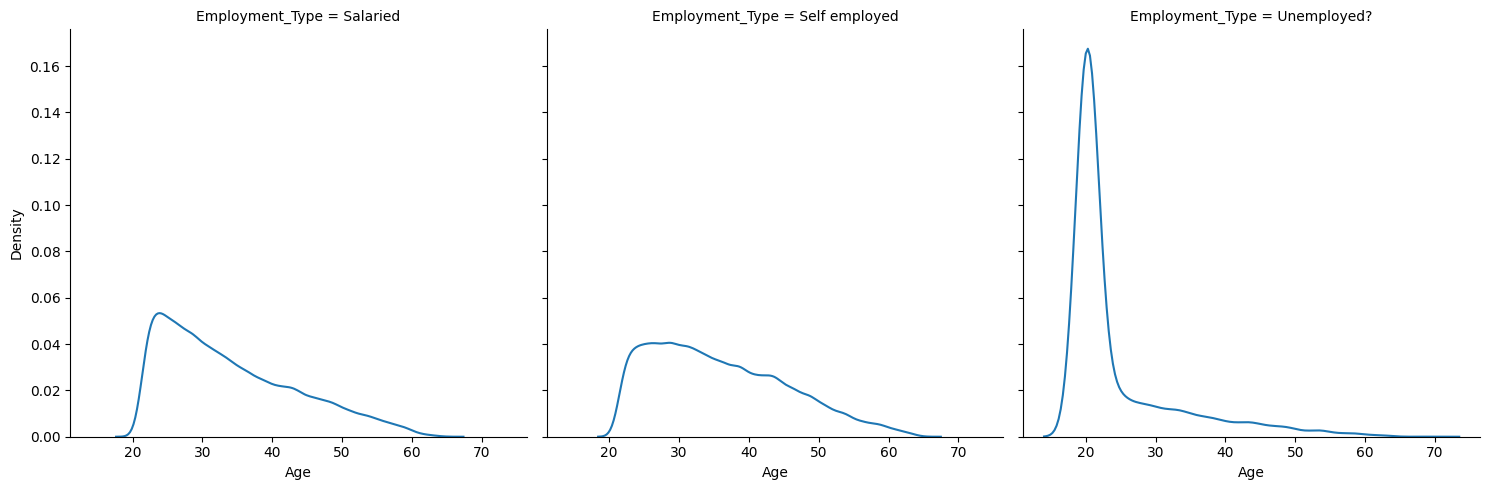

In [24]:
sns.displot(data=df.fillna("Unemployed?"), x='Age', kind='kde', col='Employment_Type', common_norm=False);

After examining relationship of 'Age' to 'Employment_Type' we know there is a high number of young people in NaNs, considerably higher than in other groups. Therefore, NaNs will be filled with 'Unemployed' value.

In [25]:
# Fill NaNs with 'Unemployed'
df['Employment_Type'] = df['Employment_Type'].fillna('Unemployed').astype('category')

Record with category 'Not Scored: More than 50 active Accounts found' for column 'PERFORM_CNS_SCORE_DESCRIPTION' will be deleted (only one value for that category).

In [26]:
# Remove rows where 'PERFORM_CNS.SCORE.DESCRIPTION' is 'Not Scored: More than 50 active Accounts found'
df = df[df['PERFORM_CNS_SCORE_DESCRIPTION'] != 'Not Scored: More than 50 active Accounts found']
df['PERFORM_CNS_SCORE_DESCRIPTION'] = df['PERFORM_CNS_SCORE_DESCRIPTION'].cat.remove_categories('Not Scored: More than 50 active Accounts found')

Next task that'll be performed is to analyse 'PERFORM_CNS_SCORE' using 'PERFORM_CNS_SCORE_DESCRIPTION' feature.

In [27]:
# Compute and display descriptive statistics of 'PERFORM_CNS_SCORE' 
# for each unique value in 'PERFORM_CNS_SCORE_DESCRIPTION'
result_df = pd.DataFrame()

for group_name, group_idx in df.groupby(by='PERFORM_CNS_SCORE_DESCRIPTION').groups.items():
    descriptives_for_group = pd.DataFrame(df.loc[group_idx, :]['PERFORM_CNS_SCORE'].describe())
    descriptives_for_group.columns = [group_name]
    result_df = pd.concat([result_df, descriptives_for_group], axis=1) 

result_df

,A-Very Low Risk,B-Very Low Risk,C-Very Low Risk,D-Very Low Risk,E-Low Risk,F-Low Risk,G-Low Risk,H-Medium Risk,I-Medium Risk,J-High Risk,K-High Risk,L-Very High Risk,M-Very High Risk,No Bureau History Available,Not Scored: No Activity seen on the customer (Inactive),Not Scored: No Updates available in last 36 months,Not Scored: Not Enough Info available on the customer,Not Scored: Only a Guarantor,Not Scored: Sufficient History Not Available
count,14124.000000,9201.000000,16045.000000,11358.000000,5821.000000,8485.000000,3988.000000,6855.000000,5557.000000,3748.000000,8277.000000,1134.000000,8776.0,116950.0,2885.0,1534.0,3672.0,976.0,3765.0
mean,827.662631,774.183893,741.899221,715.958091,691.517437,666.064467,640.853561,617.031947,586.832644,549.876734,440.594177,326.601411,300.0,0.0,16.0,18.0,17.0,14.0,15.0
std,8.823007,11.822008,6.771192,8.845807,7.682191,10.147717,5.541654,8.324398,9.381104,14.373929,45.119794,15.135395,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,806.000000,761.000000,736.000000,706.000000,681.000000,651.000000,631.000000,601.000000,571.000000,521.000000,351.000000,301.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
25%,825.000000,763.000000,738.000000,708.000000,684.000000,657.000000,636.000000,610.000000,579.000000,539.000000,405.000000,312.250000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
50%,825.000000,772.000000,738.000000,712.000000,692.000000,666.000000,640.000000,616.000000,587.000000,552.000000,441.000000,327.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
75%,832.000000,783.000000,746.000000,725.000000,698.000000,677.000000,646.000000,624.000000,596.000000,563.000000,477.000000,340.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
max,890.000000,805.000000,760.000000,735.000000,705.000000,680.000000,650.000000,630.000000,600.000000,570.000000,520.000000,350.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0


Categories from A to L are nicely cut, however there is a problem with columns beginning with 'Not Scored', because their values for 'PERFORM_CNS_SCORE' are encoded as 16, 18, 17, 14 & 15 respectively. They will be replaced with 0.

In [28]:
# Replacing values for 'PERFORM_CNS_SCORE' lower than 300 with 0
df.loc[df['PERFORM_CNS_SCORE'] < 300, 'PERFORM_CNS_SCORE'] = 0

# Other columns

In [29]:
df['DisbursalDate'].dt.year.value_counts()

2018    233151
Name: DisbursalDate, dtype: int64

All disbursal dates are from year 2018.

# Feature engineering

### Numerical features

Bunch of derived column will be created and most of them will represent ratios between two features.

In [30]:
credit_history_length_months = df['CREDIT_HISTORY_LENGTH'].apply(lambda x: pd.DateOffset(months=x))
date_of_first_loan = pd.Timestamp(2019, 1, 1) - credit_history_length_months

df['Age_First_Loan'] = ((date_of_first_loan - df['Date_of_Birth']) / np.timedelta64(1, 'Y'))

# Combine primary and secondary columns into totals
tot_cols = [f'TOT_{c.split("PRI_")[1]}' for c in pri_cols]
df[tot_cols] = df[pri_cols].values + df[sec_cols].values

# Adding 1e-4 to avoid dividing by zero
df['PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO'] = df['PRI_OVERDUE_ACCTS'] / (1e-4 + df['PRI_ACTIVE_ACCTS'])
df['SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO'] = df['SEC_OVERDUE_ACCTS'] / (1e-4 + df['SEC_ACTIVE_ACCTS'])
df['TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO'] = df['TOT_OVERDUE_ACCTS'] / (1e-4 + df['TOT_ACTIVE_ACCTS'])

df['PRI_ACTIVE_ACCTS_RATIO'] = df['PRI_ACTIVE_ACCTS'] / (1e-4 + df['PRI_NO_OF_ACCTS'])
df['SEC_ACTIVE_ACCTS_RATIO'] = df['SEC_ACTIVE_ACCTS'] / (1e-4 + df['SEC_NO_OF_ACCTS'])
df['TOT_ACTIVE_ACCTS_RATIO'] = df['TOT_ACTIVE_ACCTS'] / (1e-4 + df['TOT_NO_OF_ACCTS'])

df['DELINQUENT_TO_NEW_ACCTS_RATIO'] = df['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'] / (1e-4 + df['NEW_ACCTS_IN_LAST_SIX_MONTHS'])
df['DELINQUENT_TO_ALL_ACCTS_RATIO'] = df['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'] / (1e-4 + df['TOT_NO_OF_ACCTS'])

df['PERFORM_CNS_SCORE_NORMALIZED_BY_ltv'] = minmax_scale(df['PERFORM_CNS_SCORE']) * (100 - df['ltv'])

derived_numerical = ['Age_First_Loan'] + tot_cols + [   
    'PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO',
    'SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO',
    'TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO',

    'PRI_ACTIVE_ACCTS_RATIO',
    'SEC_ACTIVE_ACCTS_RATIO',
    'TOT_ACTIVE_ACCTS_RATIO',

    'DELINQUENT_TO_NEW_ACCTS_RATIO',
    'DELINQUENT_TO_ALL_ACCTS_RATIO',

    'PERFORM_CNS_SCORE_NORMALIZED_BY_ltv',
]
numerical.extend(derived_numerical)

pri_cols.extend(['PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO', 'PRI_ACTIVE_ACCTS_RATIO'])
sec_cols.extend(['SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO', 'SEC_ACTIVE_ACCTS_RATIO'])
tot_cols.extend(['TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO', 'TOT_ACTIVE_ACCTS_RATIO'])

# Every TOT column will be of same data type as its respective PRI column
df = df.astype(
    {tot_col: df[pri_col].dtypes.str for tot_col, pri_col in zip(tot_cols, pri_cols)}
)

Derived numerical columns



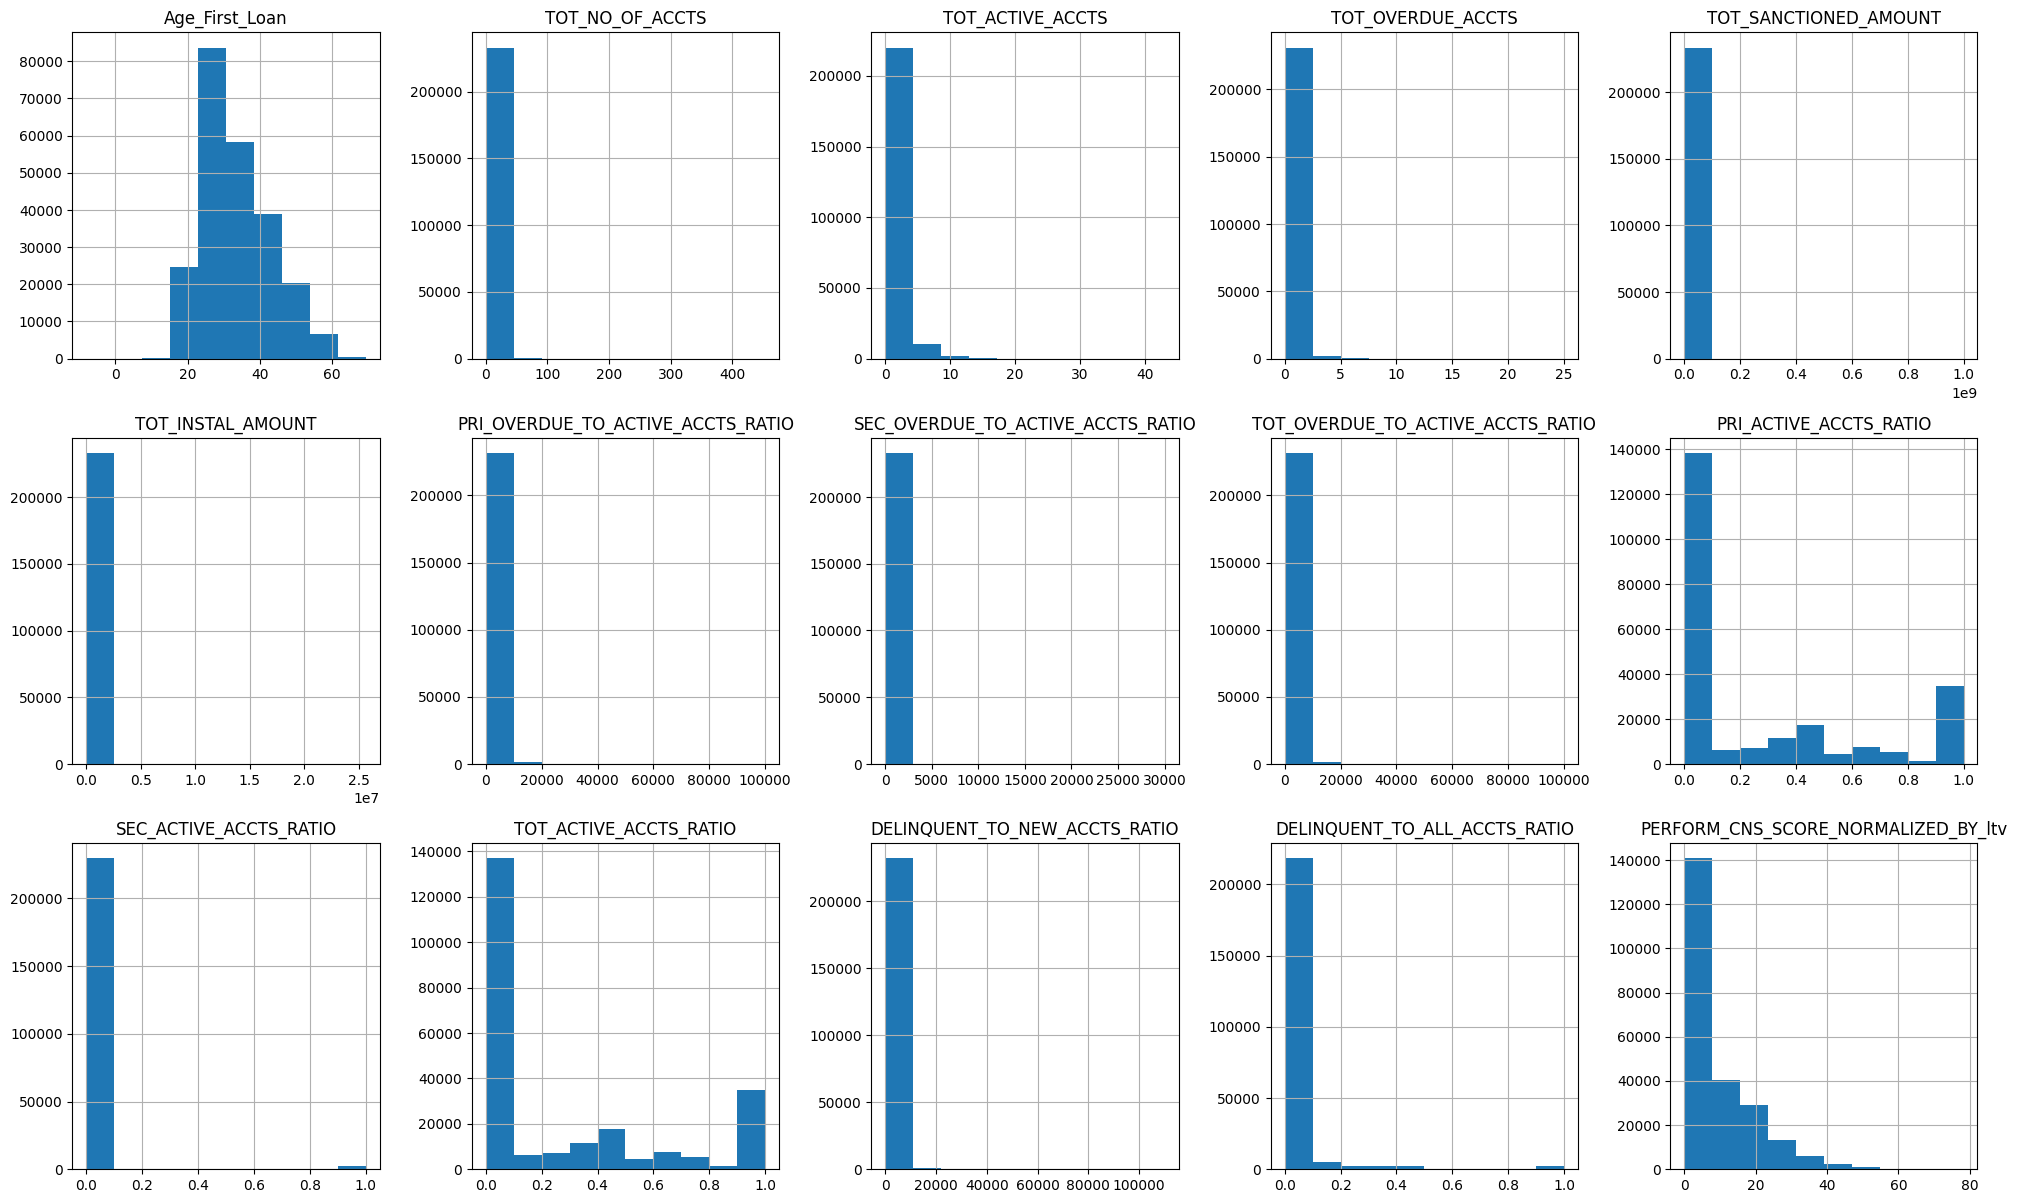

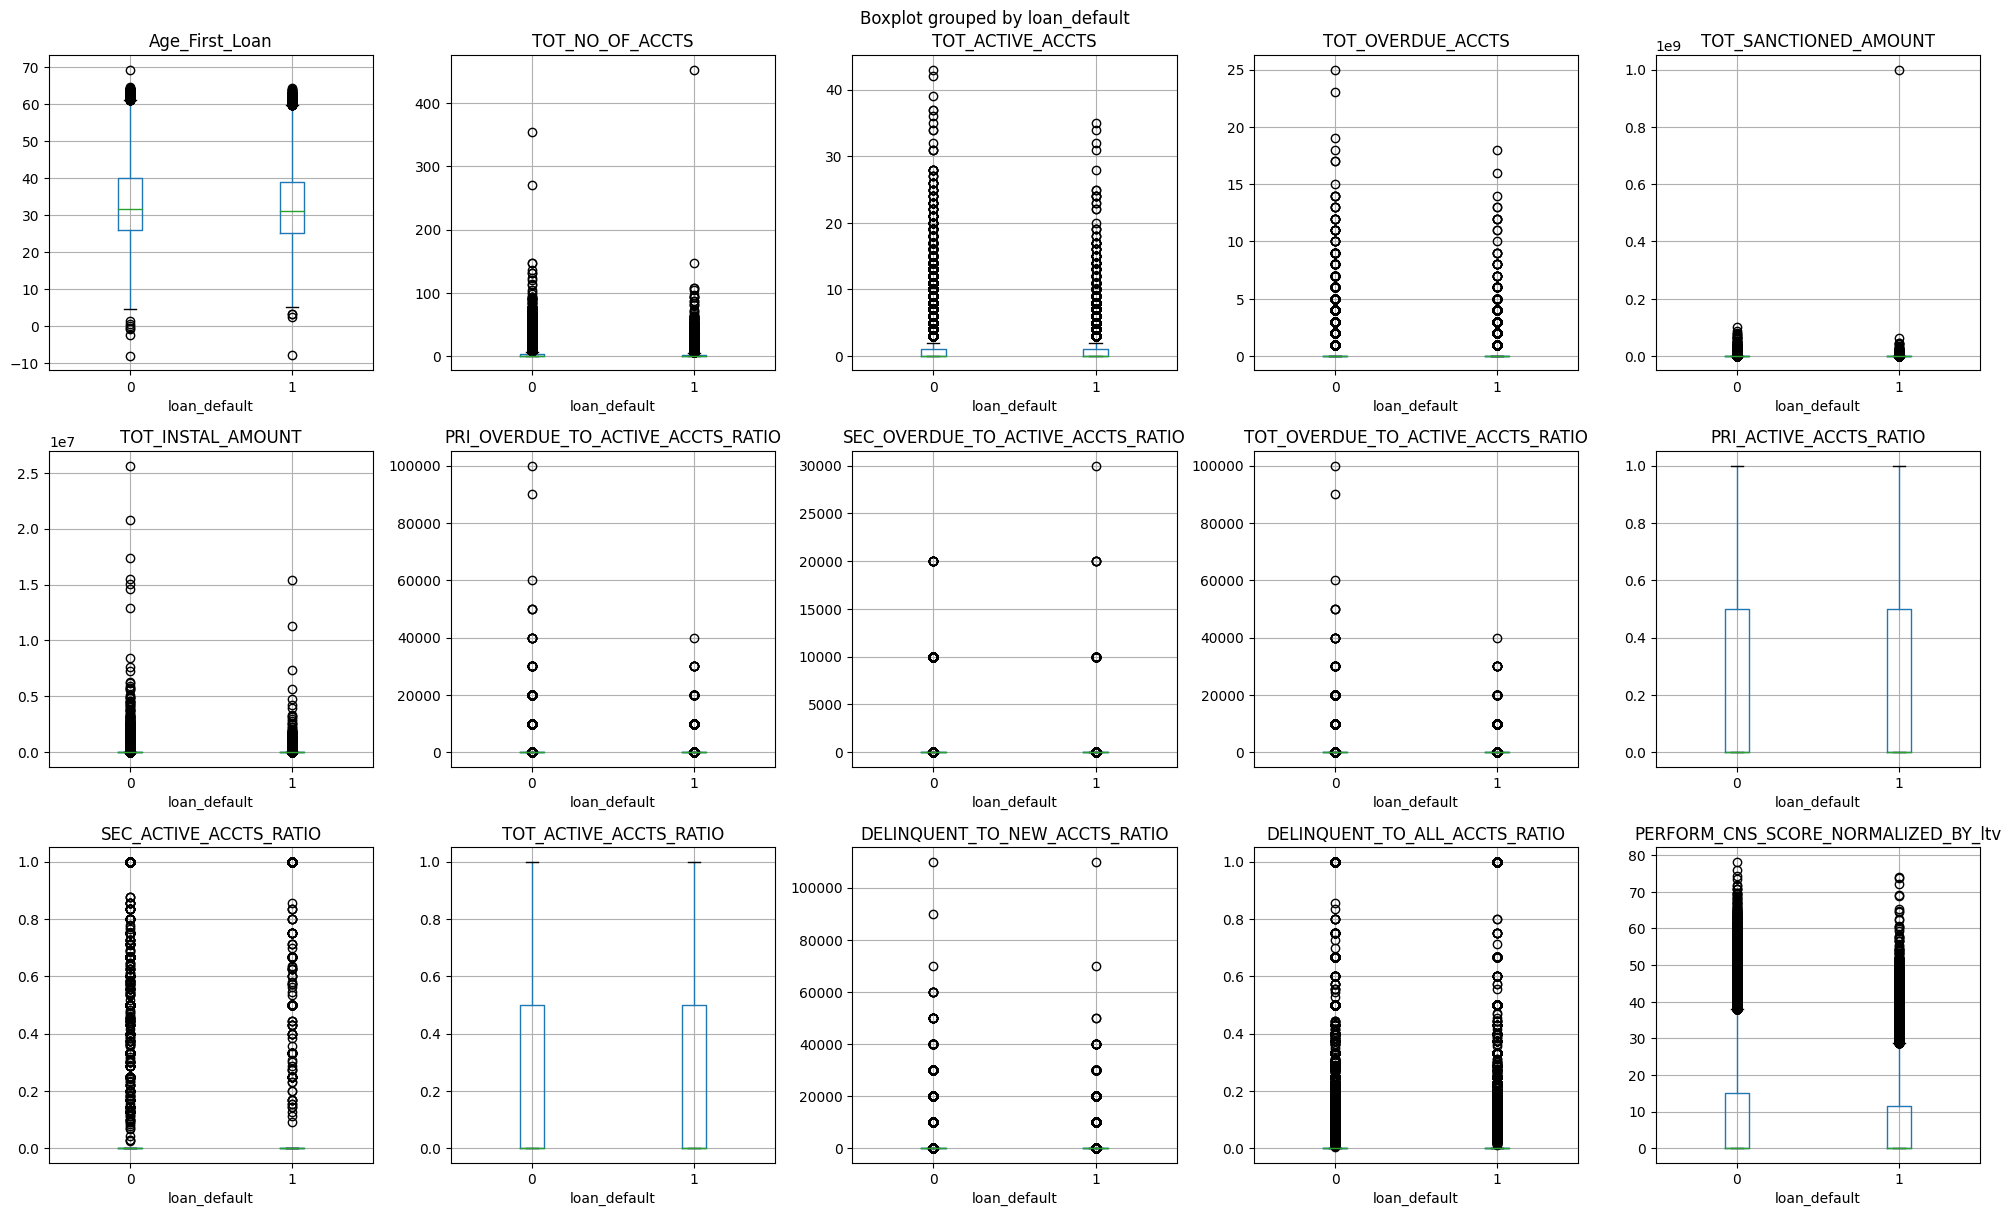

,Age_First_Loan,TOT_NO_OF_ACCTS,TOT_ACTIVE_ACCTS,TOT_OVERDUE_ACCTS,TOT_SANCTIONED_AMOUNT,TOT_INSTAL_AMOUNT,PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO,SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO,TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO,PRI_ACTIVE_ACCTS_RATIO,SEC_ACTIVE_ACCTS_RATIO,TOT_ACTIVE_ACCTS_RATIO,DELINQUENT_TO_NEW_ACCTS_RATIO,DELINQUENT_TO_ALL_ACCTS_RATIO,PERFORM_CNS_SCORE_NORMALIZED_BY_ltv
count,233151.000000,233151.000000,233151.000000,233151.000000,2.331510e+05,2.331510e+05,233151.000000,233151.000000,233151.000000,233151.000000,233151.000000,233151.000000,233151.000000,233151.000000,233151.000000
mean,33.388425,2.498317,1.066493,0.163774,2.248086e+05,1.342644e+04,84.092805,12.871012,85.853278,0.268639,0.013233,0.271383,476.549771,0.027047,7.818694
std,9.435420,5.271189,1.954801,0.564397,2.365251e+06,1.523317e+05,1094.017549,380.533033,1106.162937,0.374917,0.108294,0.375036,2565.923854,0.126037,10.817819
min,-8.079564,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.733588,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.496882,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39.748934,3.000000,1.000000,0.000000,6.563500e+04,2.083000e+03,0.000000,0.000000,0.000000,0.499988,0.000000,0.499988,0.000000,0.000000,14.276770
max,69.296426,453.000000,43.000000,25.000000,1.000000e+09,2.564281e+07,100000.000000,30000.000000,100000.000000,0.999994,0.999992,0.999994,110000.000000,0.999990,78.254494


In [31]:
print("Derived numerical columns")
print()

# Display histograms
df.hist(column=derived_numerical, figsize=(20, 20), layout=(5, 5))
plt.tight_layout()
plt.show();

# Display boxplots
df.boxplot(column=derived_numerical, figsize=(20, 20), by=LABEL, layout=(5,5), sharey=False, sharex=False)
plt.tight_layout()
plt.show();

df[derived_numerical].describe()

From descriptive statistics table we see column 'Age_First_Loan' has minimal value of -7 and notable number of "outliers" (deducted from the boxplot). Let's see how many persons there are who are less than 16.

Number of people with invalid 'Age_First_Loan' (age less than 16): 378


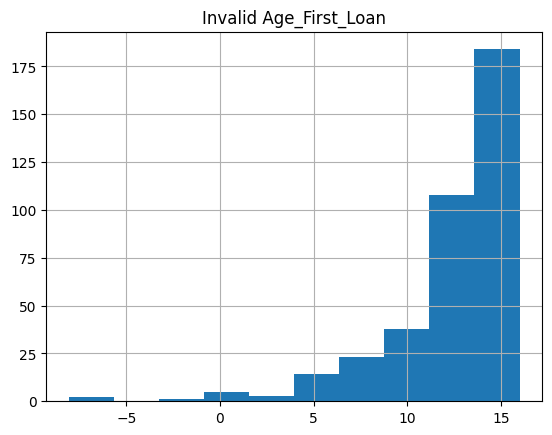

In [32]:
n_people_invalid_age_first_loan = (df['Age_First_Loan'] < 16).sum()
print(f"Number of people with invalid 'Age_First_Loan' (age less than 16): {n_people_invalid_age_first_loan}")

df.loc[df['Age_First_Loan'] < 16, 'Age_First_Loan'].hist()
plt.title("Invalid Age_First_Loan");

People who had their loan before age 16 will be removed from the dataset.

In [33]:
rows_to_remove_idx = df.index[df['Age_First_Loan'] < 16].to_list()

# Removing people with invalid value of 'Age_First_Loan' column
df.drop(rows_to_remove_idx, inplace=True)

# Saving indices to remove so they can be removed in modelling
with open("data/rows_to_remove_idx.pickle", "wb") as file:
    pickle.dump(rows_to_remove_idx, file)

del file

It's wise to see correlations again with the newly derived features.

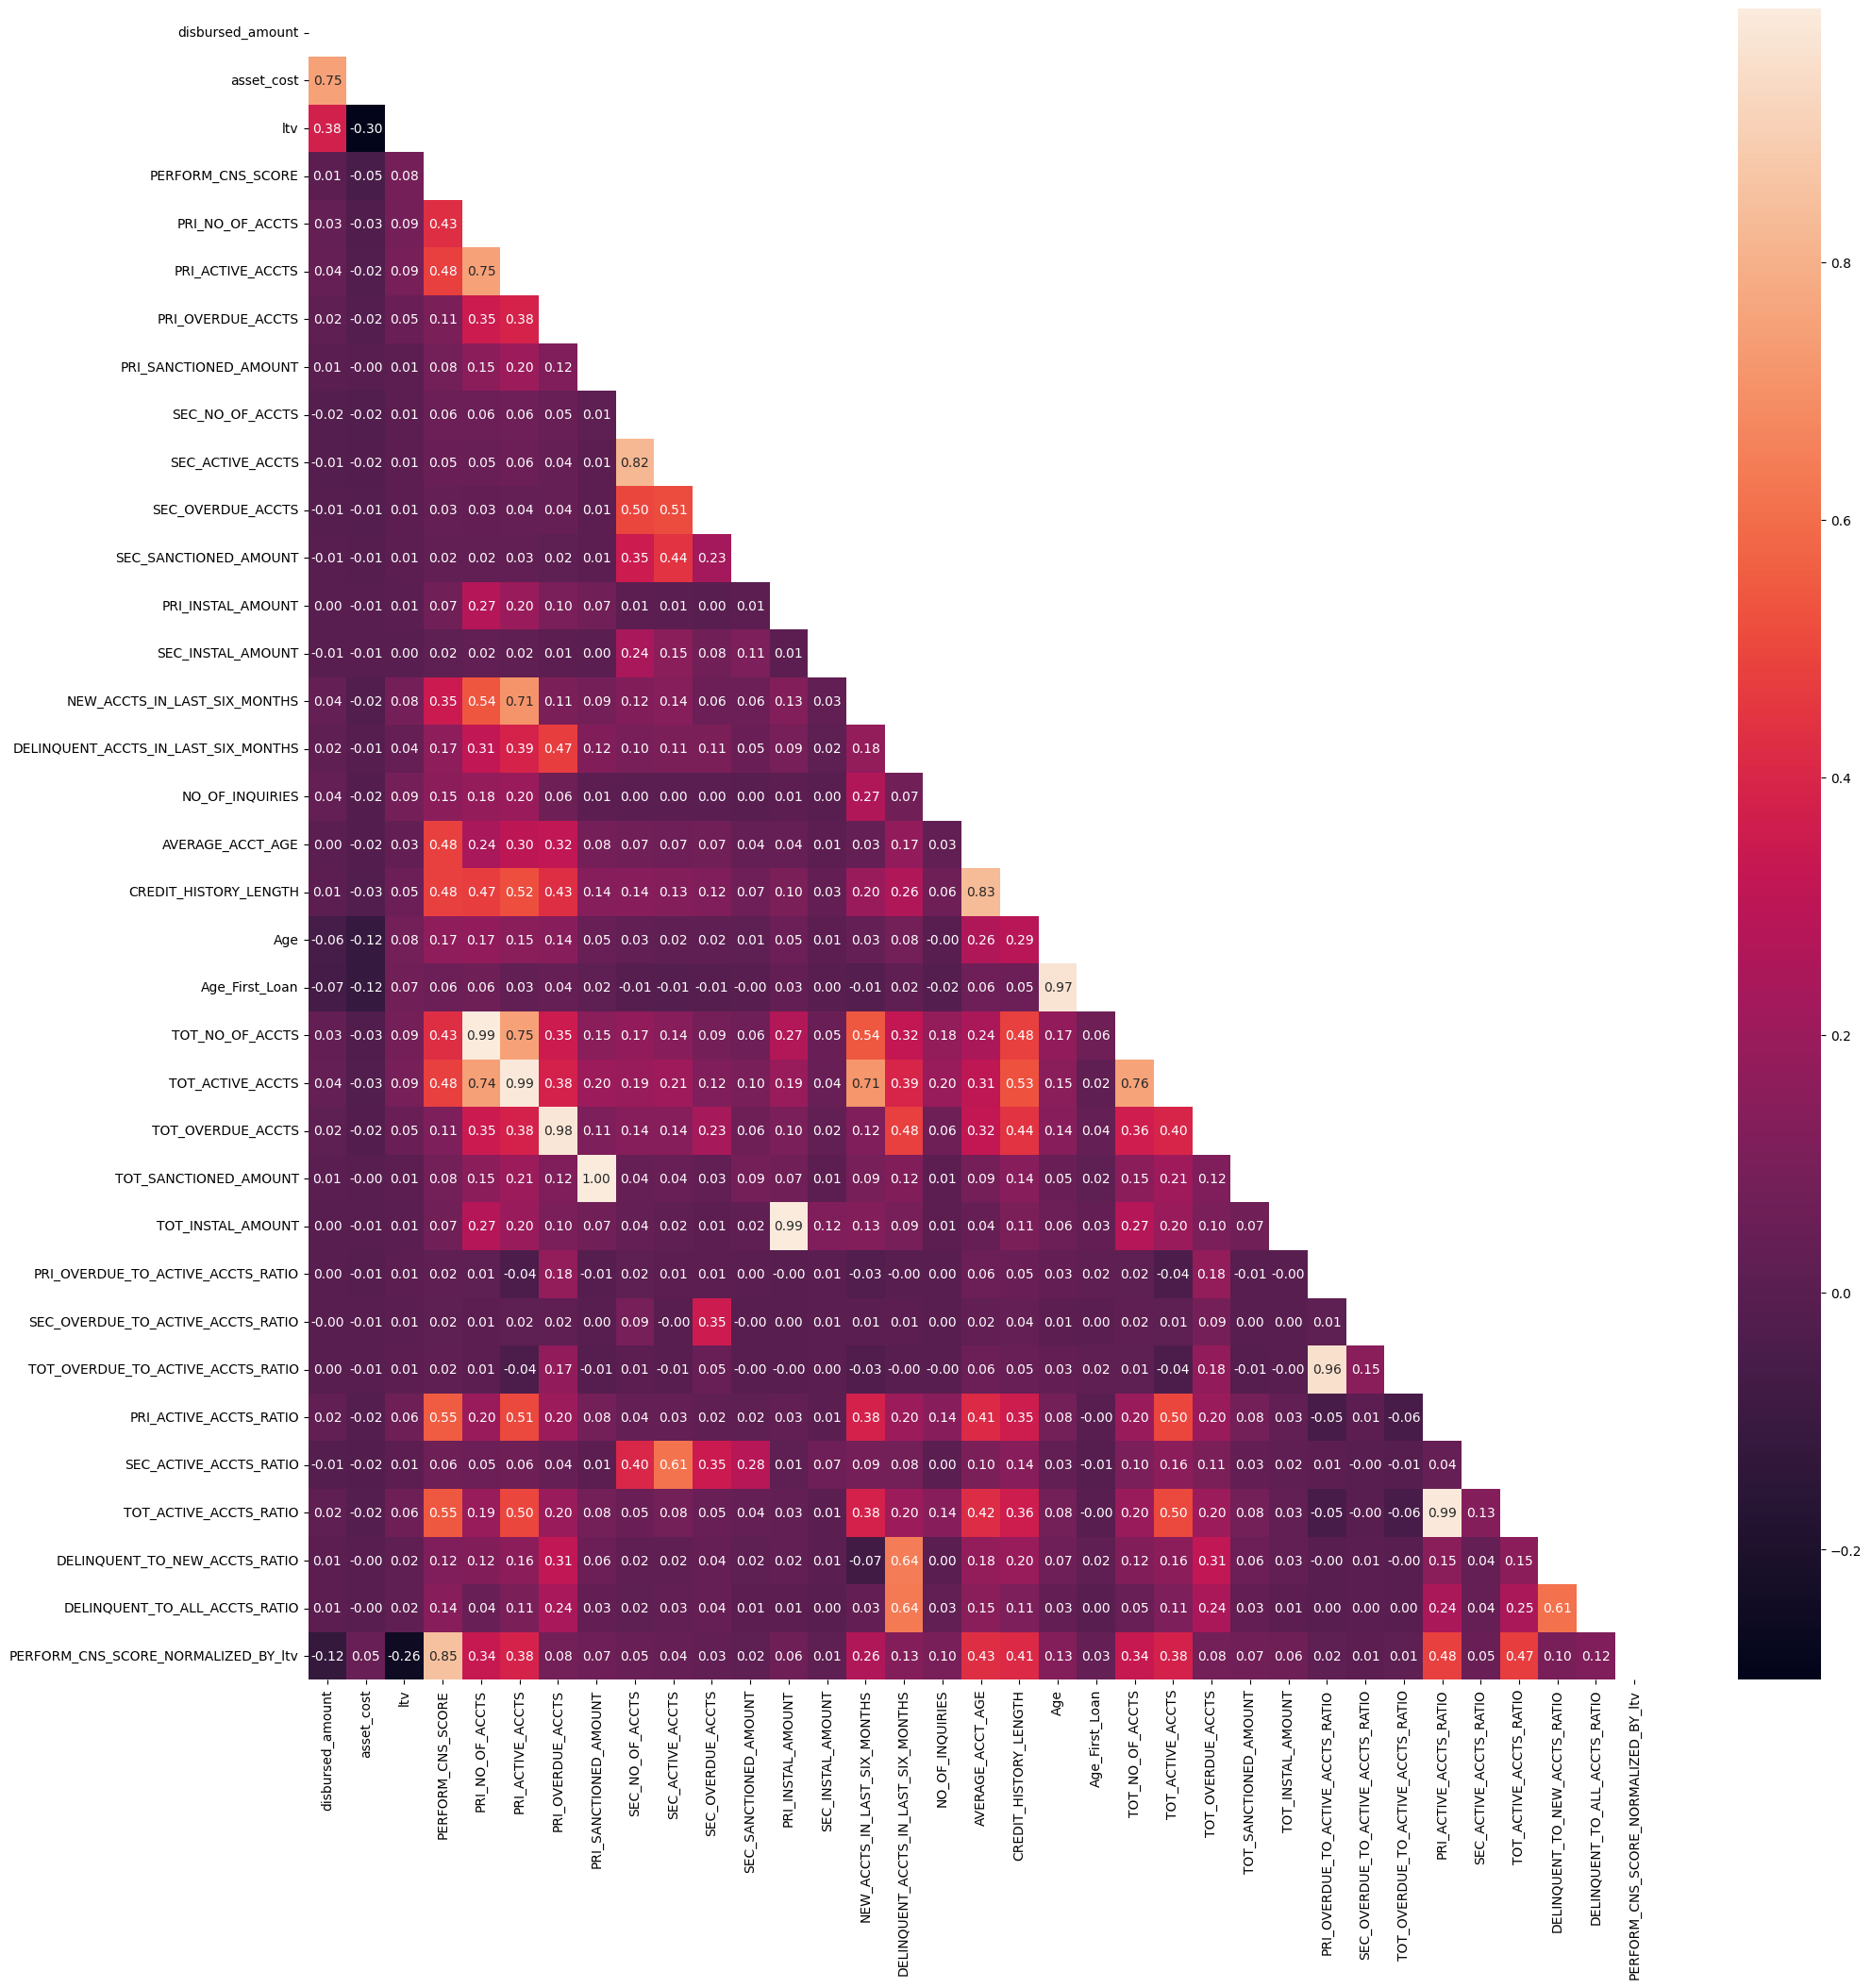

In [34]:
plt.figure(figsize=(23, 23))

corr = df[numerical].corr()

# Upper triangular heatmap of correlations with annotations
sns.heatmap(corr, annot=True, mask=np.triu(corr), fmt='.2f');

All TOT cols have almost 1.00 Pearsons correlation. To determine what columns will be kept, f_classif from sklearn will be applied for PRI & TOT cols. The columns with lesser information gain will be dropped.

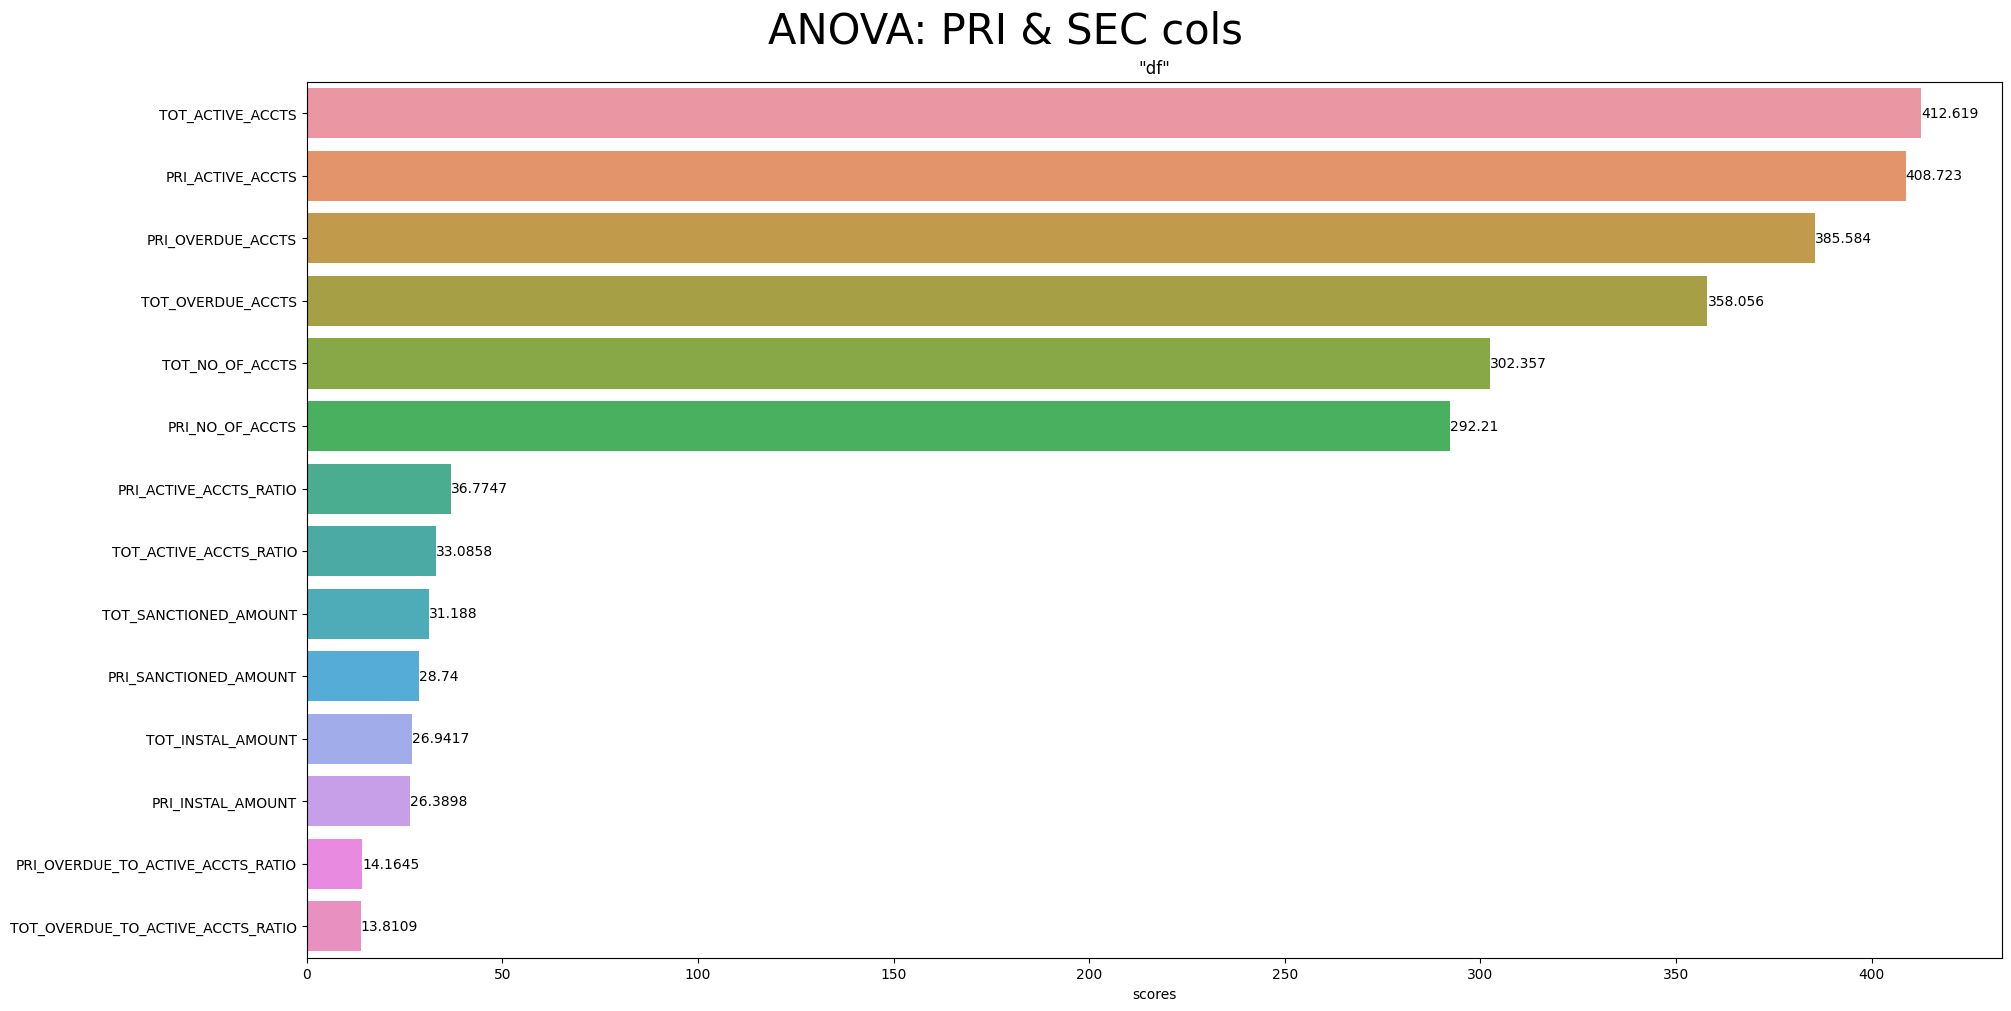

In [35]:
hp.visualize_anova_importance([('df', df)], 'PRI & SEC cols', pri_cols + tot_cols)

Let's see correlations between 'Age_First_Loan', 'Age', since they have +0.97 correlation.

Histogram: 'Age_First_Loan' vs 'Age'


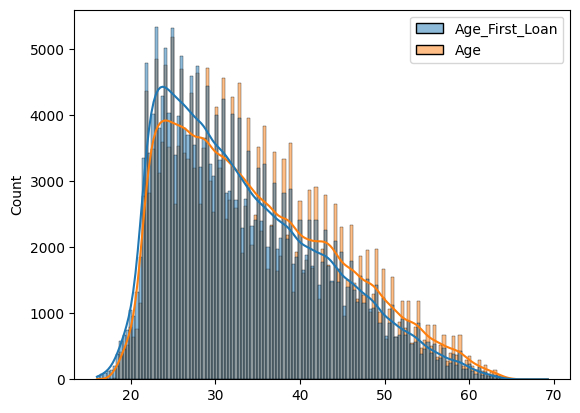

Scatter plot: 'Age_First_Loan' vs 'Age'


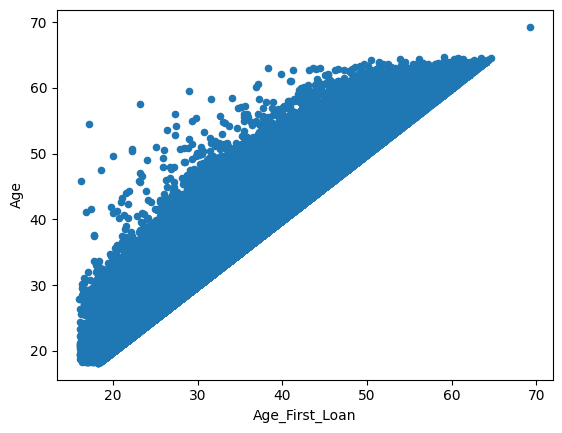

In [36]:
print("Histogram: 'Age_First_Loan' vs 'Age'")
sns.histplot(data=df[['Age_First_Loan', 'Age']], kde=True)
plt.show()

print("Scatter plot: 'Age_First_Loan' vs 'Age'")
df.plot(kind="scatter", x='Age_First_Loan', y='Age')
plt.show()

The columns have almost the same distribution, so 'Age_First_Loan' will be deleted, because column 'CREDIT_HISTORY_LENGTH' is more descriptive.

In [37]:
# Define columns for dropping
to_drop = ['PRI_ACTIVE_ACCTS', 'TOT_OVERDUE_ACCTS', 'PRI_NO_OF_ACCTS', 'TOT_ACTIVE_ACCTS_RATIO',
           'PRI_SANCTIONED_AMOUNT', 'PRI_INSTAL_AMOUNT', 'TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO',
           'Age_First_Loan']

# Delete cols from df
df = df.drop(to_drop, axis=1)

# Update numerical and derived_numerical list of cols respectively
numerical = [a for a in numerical if a not in to_drop] 
[derived_numerical.remove(a) for a in to_drop if "TOT_" in a];

### Categorical features

The process of engineering new categorical features will be more complicated when we compare it with engineered numerical features: 
<ul>
<li>
'No_Of_Holidays_In_First_Disbursal_Month' will be calculated using holidays library and finding all Indian holidays that will contain period starting from 'DisbursalDate' and one month from it. The intuition is this: if there are a lot of holidays in that period, loanee may struggle to pay monthly amount of loan because he already spent some money preparing for the holidays (food, drinks and other expenses); it's not longer than one month because 'loan_default' describes <i>Payment default in the first EMI on due date</i>, where EMI stands for Equated <b>monthly</b> instalments.</li>
<li>'Month_of_Birth' is calculated using loanee's 'Date_of_Birth'</li>
<li>'shared_documents' is calculated by adding all flag categories</li>
</ul>

In [38]:
df['No_Of_Holidays_In_First_Disbursal_Month'] = df['DisbursalDate'].apply(lambda x: hp.calculate_no_of_holidays(x, INDIA_HOLIDAYS)).astype('int8')
df['Month_of_Birth'] = df['Date_of_Birth'].dt.month.astype('category')
df['shared_documents'] = (df['Aadhar_flag'] + df['PAN_flag'] + df['VoterID_flag'] + df['Driving_flag']).astype('category')

ordinal.extend(['shared_documents',
                'No_Of_Holidays_In_First_Disbursal_Month'
])
nominal.append('Month_of_Birth')
derived_ordinal = ['shared_documents', 
                    'No_Of_Holidays_In_First_Disbursal_Month',
]
derived_nominal = ['Month_of_Birth']

In [39]:
# Display value counts for every derived categorical column
for col in derived_ordinal + derived_nominal:
    print(f"Column: {col}")
    c = df[col].value_counts(dropna=False)
    p = df[col].value_counts(dropna=False, normalize=True) * 100

    display(pd.concat([c, p], axis=1, keys=['counts', '%']))
    print()

Column: shared_documents


,counts,%
1,212780,91.410945
2,19307,8.294347
0,369,0.158524
3,314,0.134895
4,3,0.001289



Column: No_Of_Holidays_In_First_Disbursal_Month


,counts,%
2,110650,47.535582
1,90876,39.040610
3,21814,9.371362
0,9433,4.052446



Column: Month_of_Birth


,counts,%
1,69069,29.672256
6,23601,10.139063
5,18209,7.822643
7,16638,7.147736
10,14918,6.408819
3,14510,6.233541
4,14499,6.228815
8,14137,6.073299
2,13938,5.987808
12,11966,5.140631


Now we are ready for the modelling part.